# InSituPy demonstration - Investigate gene expression along an axis using kernel densities

In [1]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from insitupy import read_xenium
import mellon
import palantir
import numpy as np
import pandas as pd

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Xenium data into `InSituData` object

Now the Xenium data can be parsed by providing the data path to the `InSituPy` project folder.

In [4]:
insitupy_project = Path("demo_dataset/demo_insitupy_project")

In [5]:
xd = read_xenium(insitupy_project)
xd.load_images()
xd.load_cells()

Loading images...
['nuclei', 'CD20', 'HER2', 'DAPI', 'HE']
Loading cells...
	No alternative cells found...


In [6]:
xd

InSituData
Method:		Xenium
Slide ID:	0001879
Sample ID:	Replicate 1
Path:		C:\Users\ge37voy\Github\InSituPy\notebooks\demo_dataset\demo_insitupy_project
Metadata file:	.ispy
    ➤ images
       nuclei:	(25778, 35416)
       CD20:	(25778, 35416)
       HER2:	(25778, 35416)
       DAPI:	(25778, 35416)
       HE:	(25778, 35416, 3)
    ➤ cells
       matrix
           AnnData object with n_obs × n_vars = 163565 × 313
           obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
           var: 'gene_ids', 'feature_types', 'genome'
           uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
           obsm: 'OT', 'X_pca', 'X_umap', 'spatial'
           varm: 'OT', 'PCs', 'binned_expression'
           layers: 'counts', 'norm_counts'
           obsp: 'connec

## Calculate distance of cells to annotations

To generate an axis we use here a selected set of annotations and calculate the distance of all cells to these annotations. For demonstration purposes we selected a region of the breast cancer dataset and annotated tumor cells within this region:
<center><img src="./demo_screenshots/tumor_region_annotation_example.png" width="600"/></center>

These annotations and the region can be imported from files in the repository but of course it would be also possible to do own annotations and select an own region and save the results using `.store_geometries()`.

In [7]:
from insitupy import calc_distance_of_cells_from

In [8]:
xd.import_annotations(
    files="./demo_annotations/annotations-Tumor.geojson",
    keys="Tumor"
)

Importing annotations...


In [9]:
xd.import_annotations(
    files="./demo_annotations/demo_annotations.geojson",
    keys="Demo"
)

Importing annotations...


In [10]:
xd.import_annotations(
    files="./demo_annotations/demo_points.geojson",
    keys="Demo"
)

Importing annotations...


In [11]:
xd.import_regions(
    files="./demo_regions/regions-Tumor.geojson",
    keys="Tumor"
)

Importing regions...


In [12]:
calc_distance_of_cells_from(
    data=xd,
    annotation_key="Demo",
    annotation_class="Tumor center",
    # region_key="Tumor",
    # region_name="Selected Tumor"
)

Calculate the distance of cells from the annotation "Tumor center"
Saved distances to `.cells.matrix.obsm["distance_from"]["Tumor center"]`


In [13]:
xd.cells.matrix.obsm["distance_from"]

Tumor center
1        2480.161784
2        2487.117058
5        2477.066531
8        2473.688216
9        2463.314224
...              ...
167776   3175.216840
167777   3200.067398
167778   3190.414884
167779   3201.076376
167780   3209.733931

[163565 rows x 1 columns]

In [14]:
mask = xd.cells.matrix.obsm["distance_from"]["Tumor center"].notna()
xd.cells.matrix.obsm["distance_from"]["Tumor center"][mask]

1         2480.161784
2         2487.117058
5         2477.066531
8         2473.688216
9         2463.314224
             ...     
167776    3175.216840
167777    3200.067398
167778    3190.414884
167779    3201.076376
167780    3209.733931
Name: Tumor center, Length: 163565, dtype: float64

### Visualize the results using `napari`

Using `.show()` we can visualize the results and see the distance values per cell:
<center><img src="./demo_screenshots/distances_from_tumor_example.jpg" width="200"/></center>


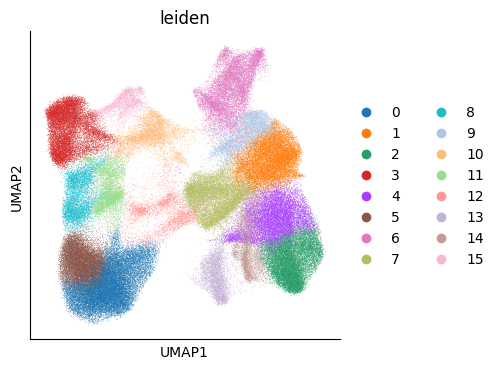

In [15]:
import scanpy as sc
sc.pl.umap(adata=xd.cells.matrix, color="leiden")

## Select small region for testing

In [16]:
xdcrop = xd.crop(region_tuple=("Tumor", "Selected Tumor"))
adata = xdcrop.cells.matrix

## Calculate density using `Mellon`

In [17]:
from insitupy.utils._calc import calc_grouped_log_density

In [18]:

# Example usage
calc_grouped_log_density(
    adata,
    groupby='cell_type',
    mode="gauss",
    inplace=True)

100%|██████████| 18/18 [00:04<00:00,  4.10it/s]


In [19]:
xdcrop.show()

Invalid schema for package 'ome-types', please run 'npe2 validate ome-types' to check for manifest errors.


c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\napari\utils\colormaps\standardize_color.py:173: UserWarning: An object array was passed as the color input. Please convert its datatype before sending it to napari. Converting input to a white color array.
  warnings.warn(
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\napari\utils\colormaps\standardize_color.py:173: UserWarning: An object array was passed as the color input. Please convert its datatype before sending it to napari. Converting input to a white color array.
  warnings.warn(
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\napari\utils\colormaps\standardize_color.py:173: UserWarning: An object array was passed as the color input. Please convert its datatype before sending it to napari. Converting input to a white color array.
  warnings.warn(
c:\Users\ge37voy\AppData\Local\miniconda3\envs\insitupy\lib\site-packages\napari\utils\colormaps\standardi

In [135]:
layers = xdcrop.viewer.layers
l = layers["main-log_density-gauss#Breast cancer"]

In [136]:
l.data

array([[  12.44843518,   73.2167788 ],
       [  17.46812512,   86.20127587],
       [  24.1340675 ,   72.30701318],
       ...,
       [2160.75225598, 2566.35238061],
       [2133.14883801, 2581.49176049],
       [2146.57120129, 2624.45369897]])

In [137]:
values = l.properties['value']

In [138]:
values

array([3.73882918e-07, 3.86550941e-07, 3.89277429e-07, ...,
                  nan,            nan,            nan])

In [139]:
from insitupy.plotting._colors import _data_to_rgba

In [143]:
catval = xdcrop.cells.matrix.obs["annotations-demo"]

In [150]:
_data_to_rgba(values)

array([(0.296479, 0.761561, 0.424223, 1.0),
       (0.344074, 0.780029, 0.397381, 1.0),
       (0.35236, 0.783011, 0.392636, 1.0), ..., (1, 1, 1, 0),
       (1, 1, 1, 0), (1, 1, 1, 0)], dtype=object)

In [151]:
_data_to_rgba(catval)

array([[1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       ...,
       [1., 1., 1., 0.],
       [1., 1., 1., 0.],
       [1., 1., 1., 0.]])

In [145]:
np.unique(_data_to_rgba(catval))

array([0.        , 0.12156863, 0.46666667, 0.70588235, 1.        ])

In [152]:
# Convert the numpy array to a pandas Series
value_series = pd.Series(values)

# check where there are nas
isna_mask = value_series.isna()
notna_mask = ~isna_mask

# get only values without NaNs
notna_values = value_series[notna_mask].values


In [153]:
notna_rgba = _data_to_rgba(notna_values)

In [154]:
result_values = pd.Series(index=value_series.index, dtype="object")

In [155]:
tuple_list = [tuple(elem) for elem in notna_rgba]

In [156]:
result_values

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
25438    NaN
25439    NaN
25440    NaN
25441    NaN
25442    NaN
Length: 25443, dtype: object

In [157]:
result_values.loc[notna_mask] = tuple_list
result_values.loc[isna_mask] = [(1,1,1,0)] * isna_mask.sum()

In [159]:
result_values

0        (0.296479, 0.761561, 0.424223, 1.0)
1        (0.344074, 0.780029, 0.397381, 1.0)
2         (0.35236, 0.783011, 0.392636, 1.0)
3        (0.404001, 0.800275, 0.362552, 1.0)
4        (0.449368, 0.813768, 0.335384, 1.0)
                        ...                 
25438                           (1, 1, 1, 0)
25439                           (1, 1, 1, 0)
25440                           (1, 1, 1, 0)
25441                           (1, 1, 1, 0)
25442                           (1, 1, 1, 0)
Length: 25443, dtype: object

In [164]:
xdcrop.show()

In [163]:
np.array(result_values.tolist())

array([[0.296479, 0.761561, 0.424223, 1.      ],
       [0.344074, 0.780029, 0.397381, 1.      ],
       [0.35236 , 0.783011, 0.392636, 1.      ],
       ...,
       [1.      , 1.      , 1.      , 0.      ],
       [1.      , 1.      , 1.      , 0.      ],
       [1.      , 1.      , 1.      , 0.      ]])

In [132]:
xdcrop.show()

In [133]:
l = xdcrop.viewer.layers["main-log_density-gauss#Breast cancer"]

In [134]:
l.face_color

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [ ]:

# remove
processed_series = series.dropna().apply(lambda x: x + '-test')

# Create a new Series to hold the final result
result_series = pd.Series(index=series.index, dtype=object)

# Fill the result series with processed values and NaNs at original positions
result_series.loc[processed_series.index] = processed_series
result_series.loc[series.isna()] = np.nan

In [35]:
_data_to_rgba(values[~np.isnan(values)])

array([[0.296479, 0.761561, 0.424223, 1.      ],
       [0.344074, 0.780029, 0.397381, 1.      ],
       [0.35236 , 0.783011, 0.392636, 1.      ],
       ...,
       [0.208623, 0.367752, 0.552675, 1.      ],
       [0.241237, 0.296485, 0.539709, 1.      ],
       [0.231674, 0.318106, 0.544834, 1.      ]])

In [46]:
a = np.array(list("abcd"))
b = [True, False, True, False]
c = [0,1]

In [38]:
a[b] = "x"

In [47]:
a[c] = ["z", "zz"]

In [48]:
a

array(['z', 'z', 'c', 'd'], dtype='<U1')

In [63]:
import numpy as np
import pandas as pd

# Sample numpy array with strings and NaN values
arr = np.array(['apple', 'banana', np.nan, 'cherry', np.nan, 'date'], dtype=object)

# Convert the numpy array to a pandas Series
series = pd.Series(arr)

# Remove NaN values and add '-test' to each element
processed_series = series.dropna().apply(lambda x: x + '-test')

# Create a new Series to hold the final result
result_series = pd.Series(index=series.index, dtype=object)

# Fill the result series with processed values and NaNs at original positions
result_series.loc[processed_series.index] = processed_series
result_series.loc[series.isna()] = np.nan

# Convert the result back to a numpy array if needed
result_array = result_series.to_numpy()

print(result_array)


['apple-test' 'banana-test' nan 'cherry-test' nan 'date-test']


In [65]:
series.loc[series.isna()] = ["z", "zz"]

In [62]:
series

0     apple
1    banana
2         z
3    cherry
4        zz
5      date
dtype: object

In [59]:
series

0         a
1         b
2         c
3    cherry
4       NaN
5      date
dtype: object

In [50]:
series

0     apple
1    banana
2       NaN
3    cherry
4       NaN
5      date
dtype: object

In [43]:
a

array(['z', 'z', 'c', 'd'], dtype='<U1')

In [39]:
a

array(['x', 'b', 'x', 'd'], dtype='<U1')

In [ ]:
l

In [27]:
l.face_color

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [26]:
l.data.shape

(25443, 2)

In [ ]:
l

In [93]:
adata.obsm["OT"]

Adipocytes       B cells  Breast cancer  Breast glandular cells  \
4305    9.300084e-14  9.182235e-14       0.502128                0.295802   
4306    2.414984e-09  5.784503e-16       0.463764                0.432100   
4307    1.444958e-20  9.174362e-19       0.481836                0.320872   
4308    4.346905e-21  6.122812e-19       0.430947                0.263066   
4309    1.882491e-21  1.588038e-11       0.421085                0.248671   
...              ...           ...            ...                     ...   
118570  7.898348e-20  2.114860e-14       0.124474                0.098350   
118571  3.232290e-15  3.372341e-04       0.148692                0.135972   
118572  5.017002e-10  9.429581e-02       0.321626                0.003830   
118575  9.533220e-08  1.603694e-08       0.286926                0.034251   
118576  1.471427e-20  3.666121e-03       0.282152                0.136191   

        Breast myoepithelial cells  Dendritic cells  Endothelial cells  \
4305                  8.119691e-02     2.893466e-23       1.111926e-03   
4306                  5.372174e-03     5.088656e-22       3.446707e-18   
4307                  9.844568e-02     5.206299e-25       7.902600e-25   
4308                  9.869838e-02     1.903275e-20       3.483564e-21   
4309                  9.878435e-02     1.045429e-26       3.386338e-21   
...                            ...              ...                ...   
118570                1.228702e-01     1.118734e-21       2.555176e-12   
118571                1.705184e-15     2.816263e-18       6.459623e-15   
118572                1.275540e-07     8.271133e-19       8.267876e-11   
118575                3.100606e-02     4.270523e-18       5.816593e-14   
118576                8.570984e-12     3.696507e-12       3.884578e-19   

        Epithelial cells   Fibroblasts   Macrophages    Mast cells  \
4305        1.139587e-01  5.802961e-03  9.105932e-15  1.456672e-21   
4306        9.876362e-02  8.152741e-22  1.659183e-11  1.359284e-22   
4307        9.884585e-02  1.769601e-14  6.151730e-25  9.492395e-25   
4308        2.072217e-01  6.622389e-05  5.383620e-15  8.856582e-23   
4309        2.314600e-01  1.089470e-11  6.083033e-22  4.595175e-25   
...                  ...           ...           ...           ...   
118570      1.937290e-17  3.333346e-01  7.969137e-06  5.301985e-20   
118571      8.584070e-05  2.216800e-01  3.333062e-01  4.365278e-11   
118572      1.569751e-15  4.812557e-01  5.621102e-02  8.938408e-11   
118575      2.517180e-19  4.504958e-01  8.884327e-02  2.113729e-16   
118576      1.643228e-15  3.333333e-01  9.384825e-02  4.355649e-23   

           Monocytes  Myeloid cells      NK cells   Neutrophils  Plasma cells  \
4305    2.422995e-25   1.060384e-23  4.040989e-25  3.836307e-19  3.816261e-24   
4306    2.255592e-26   9.835637e-25  3.758787e-26  3.435700e-20  3.535570e-25   
4307    2.926894e-27   3.098483e-25  6.429993e-27  7.347905e-20  1.325323e-25   
4308    1.469868e-26   6.410704e-25  2.449566e-26  2.242584e-20  2.304421e-25   
4309    8.372195e-29   4.143113e-27  1.436923e-28  3.147979e-22  1.547482e-27   
...              ...            ...           ...           ...           ...   
118570  9.180697e-24   4.255167e-22  6.856103e-16  2.371823e-17  1.559245e-22   
118571  6.268229e-02   1.654934e-12  1.490695e-06  5.597591e-16  1.097067e-21   
118572  3.255471e-15   4.204995e-19  1.502732e-06  7.752801e-14  1.727638e-19   
118575  6.159791e-18   1.589325e-18  6.747772e-07  6.586397e-14  5.729386e-19   
118576  4.313563e-24   7.057683e-22  1.489241e-22  2.664129e-16  8.452605e-23   

        Smooth muscle cells       T cells  
4305           5.894596e-08  2.032325e-08  
4306           2.677207e-26  8.162562e-13  
4307           4.510923e-19  1.853107e-16  
4308           2.531749e-23  7.233356e-17  
4309           1.864782e-18  6.535469e-12  
...                     ...           ...  
118570         2.031843e-07  3.209622e-01  
118571         1.132650e-10  9

In [74]:
df = adata.obsm["log_density-gauss"]

In [102]:
xdcrop.show()

In [103]:
df["Breast cancer"]

4305      3.738829e-07
4306      3.865509e-07
4307      3.892774e-07
4308      4.005023e-07
4309      4.108696e-07
              ...     
118570             NaN
118571             NaN
118572             NaN
118575             NaN
118576             NaN
Name: Breast cancer, Length: 25443, dtype: float64

In [112]:
xdcrop.show()

In [110]:
xdcrop.cells.matrix.obsm["OT"]["Breast cancer"]

4305      0.502128
4306      0.463764
4307      0.481836
4308      0.430947
4309      0.421085
            ...   
118570    0.124474
118571    0.148692
118572    0.321626
118575    0.286926
118576    0.282152
Name: Breast cancer, Length: 25443, dtype: float64

In [107]:
xdcrop.cells.matrix.obs

transcript_counts  control_probe_counts  control_codeword_counts  \
4305                  315                     0                        0   
4306                  348                     0                        0   
4307                  117                     0                        0   
4308                  165                     0                        0   
4309                  335                     0                        0   
...                   ...                   ...                      ...   
118570                216                     0                        0   
118571                202                     1                        0   
118572                189                     0                        0   
118575                220                     1                        0   
118576                243                     1                        0   

        total_counts   cell_area  nucleus_area  n_genes leiden  \
4305             315  256.668125     65.702344       85      0   
4306             348  143.822656    104.446406       75      0   
4307             117  125.353750     19.642969       49      5   
4308             165  180.173438     32.015781       57      0   
4309             335  187.262969     49.355781       82      0   
...              ...         ...           ...      ...    ...   
118570           216  326.570000     29.035469       72      4   
118571           203  482.810625     24.068281       86      7   
118572           189  353.889531     11.334219       75      9   
118575           221  325.079844     17.565781       73      1   
118576           244  532.572813     29.035469      100      1   

       annotations-TestKey annotations-demo annotations-demo2  \
4305                   NaN              NaN               NaN   
4306                   NaN              NaN               NaN   
4307                   NaN              NaN               NaN   
4308                   NaN              NaN               NaN   
4309                   NaN              NaN               NaN   
...                    ...              ...               ...   
118570                 NaN              NaN               NaN   
118571                 NaN              NaN               NaN   
118572                 NaN              NaN               NaN   
118575                 NaN              NaN               NaN   
118576                 NaN              NaN               NaN   

       annotations-demo3      cell_type  
4305                 NaN  Breast cancer  
4306                 NaN  Breast cancer  
4307                 NaN  Breast cancer  
4308                 NaN  Breast cancer  
4309                 NaN  Breast cancer  
...                  ...            ...  
118570               NaN    Fibroblasts  
118571               NaN    Macrophages  
118572               NaN    Fibroblasts  
118575               NaN    Fibroblasts  
118576               NaN    Fibroblasts  

[25443 rows x 13 columns]

In [115]:
xdcrop.cells.matrix.obs["test"] = df["Breast cancer"]

In [116]:
xdcrop.show()

# Not possible to plot the kernel density results currently. Not clear what it is but could it be that it is not possible to plot continuous data if there are NaNs in it?

In [118]:
xdcrop.cells.matrix.obsm["OT"]["Breast cancer"][0] = np.nan

In [119]:
xdcrop.cells.matrix.obsm["OT"]["Breast cancer"]

4305           NaN
4306      0.463764
4307      0.481836
4308      0.430947
4309      0.421085
            ...   
118570    0.124474
118571    0.148692
118572    0.321626
118575    0.286926
118576    0.282152
Name: Breast cancer, Length: 25443, dtype: float64

In [120]:
xdcrop.show()

# Checked that and YES, as soon as there is a NaN in continuous data, it fails

In [113]:
df

Breast cancer  Breast glandular cells  Endothelial cells  \
4305     3.738829e-07                     NaN                NaN   
4306     3.865509e-07                     NaN                NaN   
4307     3.892774e-07                     NaN                NaN   
4308     4.005023e-07                     NaN                NaN   
4309     4.108696e-07                     NaN                NaN   
...               ...                     ...                ...   
118570            NaN                     NaN                NaN   
118571            NaN                     NaN                NaN   
118572            NaN                     NaN                NaN   
118575            NaN                     NaN                NaN   
118576            NaN                     NaN                NaN   

        Smooth muscle cells  T cells   Macrophages   Fibroblasts  B cells  \
4305                    NaN      NaN           NaN           NaN      NaN   
4306                    NaN      NaN           NaN           NaN      NaN   
4307                    NaN      NaN           NaN           NaN      NaN   
4308                    NaN      NaN           NaN           NaN      NaN   
4309                    NaN      NaN           NaN           NaN      NaN   
...                     ...      ...           ...           ...      ...   
118570                  NaN      NaN           NaN  1.188562e-07      NaN   
118571                  NaN      NaN  9.559258e-08           NaN      NaN   
118572                  NaN      NaN           NaN  1.101983e-07      NaN   
118575                  NaN      NaN           NaN  1.263467e-07      NaN   
118576                  NaN      NaN           NaN  1.167958e-07      NaN   

        Dendritic cells  Monocytes  NK cells  Epithelial cells  \
4305                NaN        NaN       NaN               NaN   
4306                NaN        NaN       NaN               NaN   
4307                NaN        NaN       NaN               NaN   
4308                NaN        NaN       NaN               NaN   
4309                NaN        NaN       NaN               NaN   
...                 ...        ...       ...               ...   
118570              NaN        NaN       NaN               NaN   
118571              NaN        NaN       NaN               NaN   
118572              NaN        NaN       NaN               NaN   
118575              NaN        NaN       NaN               NaN   
118576              NaN        NaN       NaN               NaN   

        Breast myoepithelial cells  Plasma cells  Myeloid cells  Mast cells  \
4305                           NaN           NaN            NaN         NaN   
4306                           NaN           NaN            NaN         NaN   
4307                           NaN           NaN            NaN         NaN   
4308                           NaN           NaN            NaN         NaN   
4309                           NaN           NaN            NaN         NaN   
...                            ...           ...            ...         ...   
118570                         NaN           NaN            NaN         NaN   
118571                         NaN           NaN            NaN         NaN   
118572                         NaN           NaN            NaN         NaN   
118575                         NaN           NaN            NaN         NaN   
118576                         NaN           NaN            NaN         NaN   

        Adipocytes  Neutrophils  
4305           NaN          NaN  
4306           NaN          NaN  
4307           NaN          NaN  
4308           NaN          NaN  
4309           NaN          NaN  
...            ...          ...  
118570         NaN          NaN  
118571         NaN          NaN  
118572         NaN          NaN  
118575         NaN          NaN  
118576         NaN          NaN  

[25443 rows x 18 columns]

In [91]:
xdcrop.show()

In [82]:
xdcrop.cells.matrix.obs

transcript_counts  control_probe_counts  control_codeword_counts  \
4305                  315                     0                        0   
4306                  348                     0                        0   
4307                  117                     0                        0   
4308                  165                     0                        0   
4309                  335                     0                        0   
...                   ...                   ...                      ...   
118570                216                     0                        0   
118571                202                     1                        0   
118572                189                     0                        0   
118575                220                     1                        0   
118576                243                     1                        0   

        total_counts   cell_area  nucleus_area  n_genes leiden  \
4305             315  256.668125     65.702344       85      0   
4306             348  143.822656    104.446406       75      0   
4307             117  125.353750     19.642969       49      5   
4308             165  180.173438     32.015781       57      0   
4309             335  187.262969     49.355781       82      0   
...              ...         ...           ...      ...    ...   
118570           216  326.570000     29.035469       72      4   
118571           203  482.810625     24.068281       86      7   
118572           189  353.889531     11.334219       75      9   
118575           221  325.079844     17.565781       73      1   
118576           244  532.572813     29.035469      100      1   

       annotations-TestKey annotations-demo annotations-demo2  \
4305                   NaN              NaN               NaN   
4306                   NaN              NaN               NaN   
4307                   NaN              NaN               NaN   
4308                   NaN              NaN               NaN   
4309                   NaN              NaN               NaN   
...                    ...              ...               ...   
118570                 NaN              NaN               NaN   
118571                 NaN              NaN               NaN   
118572                 NaN              NaN               NaN   
118575                 NaN              NaN               NaN   
118576                 NaN              NaN               NaN   

       annotations-demo3      cell_type  
4305                 NaN  Breast cancer  
4306                 NaN  Breast cancer  
4307                 NaN  Breast cancer  
4308                 NaN  Breast cancer  
4309                 NaN  Breast cancer  
...                  ...            ...  
118570               NaN    Fibroblasts  
118571               NaN    Macrophages  
118572               NaN    Fibroblasts  
118575               NaN    Fibroblasts  
118576               NaN    Fibroblasts  

[25443 rows x 13 columns]

In [86]:
xdcrop.cells.matrix.obsm["log_density-gauss"]

Breast cancer  Breast glandular cells  Endothelial cells  \
4305     3.738829e-07                     NaN                NaN   
4306     3.865509e-07                     NaN                NaN   
4307     3.892774e-07                     NaN                NaN   
4308     4.005023e-07                     NaN                NaN   
4309     4.108696e-07                     NaN                NaN   
...               ...                     ...                ...   
118570            NaN                     NaN                NaN   
118571            NaN                     NaN                NaN   
118572            NaN                     NaN                NaN   
118575            NaN                     NaN                NaN   
118576            NaN                     NaN                NaN   

        Smooth muscle cells  T cells   Macrophages   Fibroblasts  B cells  \
4305                    NaN      NaN           NaN           NaN      NaN   
4306                    NaN      NaN           NaN           NaN      NaN   
4307                    NaN      NaN           NaN           NaN      NaN   
4308                    NaN      NaN           NaN           NaN      NaN   
4309                    NaN      NaN           NaN           NaN      NaN   
...                     ...      ...           ...           ...      ...   
118570                  NaN      NaN           NaN  1.188562e-07      NaN   
118571                  NaN      NaN  9.559258e-08           NaN      NaN   
118572                  NaN      NaN           NaN  1.101983e-07      NaN   
118575                  NaN      NaN           NaN  1.263467e-07      NaN   
118576                  NaN      NaN           NaN  1.167958e-07      NaN   

        Dendritic cells  Monocytes  NK cells  Epithelial cells  \
4305                NaN        NaN       NaN               NaN   
4306                NaN        NaN       NaN               NaN   
4307                NaN        NaN       NaN               NaN   
4308                NaN        NaN       NaN               NaN   
4309                NaN        NaN       NaN               NaN   
...                 ...        ...       ...               ...   
118570              NaN        NaN       NaN               NaN   
118571              NaN        NaN       NaN               NaN   
118572              NaN        NaN       NaN               NaN   
118575              NaN        NaN       NaN               NaN   
118576              NaN        NaN       NaN               NaN   

        Breast myoepithelial cells  Plasma cells  Myeloid cells  Mast cells  \
4305                           NaN           NaN            NaN         NaN   
4306                           NaN           NaN            NaN         NaN   
4307                           NaN           NaN            NaN         NaN   
4308                           NaN           NaN            NaN         NaN   
4309                           NaN           NaN            NaN         NaN   
...                            ...           ...            ...         ...   
118570                         NaN           NaN            NaN         NaN   
118571                         NaN           NaN            NaN         NaN   
118572                         NaN           NaN            NaN         NaN   
118575                         NaN           NaN            NaN         NaN   
118576                         NaN           NaN            NaN         NaN   

        Adipocytes  Neutrophils  
4305           NaN          NaN  
4306           NaN          NaN  
4307           NaN          NaN  
4308           NaN          NaN  
4309           NaN          NaN  
...            ...          ...  
118570         NaN          NaN  
118571         NaN          NaN  
118572         NaN          NaN  
118575         NaN          NaN  
118576         NaN          NaN  

[25443 rows x 18 columns]

In [ ]:
df.clip(lower=)

In [69]:
xdcrop.cells.matrix.obs_names

Index(['4305', '4306', '4307', '4308', '4309', '4310', '4311', '4312', '4313',
       '4314',
       ...
       '118565', '118566', '118567', '118568', '118569', '118570', '118571',
       '118572', '118575', '118576'],
      dtype='object', length=25443)

In [66]:
xdcrop.show()

In [46]:
# Example usage
calc_grouped_log_density(
    adata,
    groupby='cell_type',
    mode="mellon",
    inplace=True)


  0%|          | 0/18 [00:00<?, ?it/s]

[2024-10-22 21:25:32,644] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (4,399) >= n_samples (4,399) and rank = 1.0.
[2024-10-22 21:25:32,646] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:32,655] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:32,658] [INFO    ] Using covariance function Matern52(ls=239.44837480917).
[2024-10-22 21:25:33,446] [INFO    ] Using rank 4,399 covariance representation.
[2024-10-22 21:25:34,647] [INFO    ] Running inference using L-BFGS-B.


  6%|▌         | 1/18 [00:04<01:10,  4.14s/it]

[2024-10-22 21:25:36,786] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (735) >= n_samples (735) and rank = 1.0.
[2024-10-22 21:25:36,787] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:36,790] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:36,792] [INFO    ] Using covariance function Matern52(ls=355.4349887523831).
[2024-10-22 21:25:36,822] [INFO    ] Using rank 735 covariance representation.
[2024-10-22 21:25:36,845] [INFO    ] Running inference using L-BFGS-B.


 11%|█         | 2/18 [00:04<00:32,  2.00s/it]

[2024-10-22 21:25:37,295] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (585) >= n_samples (585) and rank = 1.0.
[2024-10-22 21:25:37,296] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:37,298] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:37,300] [INFO    ] Using covariance function Matern52(ls=311.61934463569906).
[2024-10-22 21:25:37,319] [INFO    ] Using rank 585 covariance representation.
[2024-10-22 21:25:37,336] [INFO    ] Running inference using L-BFGS-B.


 17%|█▋        | 3/18 [00:04<00:18,  1.24s/it]

[2024-10-22 21:25:37,624] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (539) >= n_samples (539) and rank = 1.0.
[2024-10-22 21:25:37,625] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:37,627] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:37,629] [INFO    ] Using covariance function Matern52(ls=404.20186883004015).
[2024-10-22 21:25:37,647] [INFO    ] Using rank 539 covariance representation.
[2024-10-22 21:25:37,661] [INFO    ] Running inference using L-BFGS-B.


 22%|██▏       | 4/18 [00:05<00:12,  1.12it/s]

[2024-10-22 21:25:37,982] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (5,252) and rank = 1.0.
[2024-10-22 21:25:37,984] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:37,992] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:37,995] [INFO    ] Using covariance function Matern52(ls=196.37242964432804).
[2024-10-22 21:25:37,996] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-10-22 21:25:42,610] [INFO    ] Using rank 5,000 covariance representation.
[2024-10-22 21:25:44,231] [INFO    ] Running inference using L-BFGS-B.


 28%|██▊       | 5/18 [00:14<00:49,  3.79s/it]

[2024-10-22 21:25:46,918] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2,304) >= n_samples (2,304) and rank = 1.0.
[2024-10-22 21:25:46,919] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:46,923] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:46,925] [INFO    ] Using covariance function Matern52(ls=337.37727877805037).
[2024-10-22 21:25:47,127] [INFO    ] Using rank 2,304 covariance representation.
[2024-10-22 21:25:47,371] [INFO    ] Running inference using L-BFGS-B.


 33%|███▎      | 6/18 [00:15<00:34,  2.92s/it]

[2024-10-22 21:25:48,134] [INFO    ] Using sparse Gaussian Process since n_landmarks (5,000) < n_samples (8,633) and rank = 1.0.
[2024-10-22 21:25:48,135] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:48,150] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:48,154] [INFO    ] Using covariance function Matern52(ls=293.46151061703705).
[2024-10-22 21:25:48,156] [INFO    ] Computing 5,000 landmarks with k-means clustering.
[2024-10-22 21:25:54,030] [INFO    ] Using rank 5,000 covariance representation.
[2024-10-22 21:25:56,167] [INFO    ] Running inference using L-BFGS-B.


 39%|███▉      | 7/18 [00:27<01:03,  5.78s/it]

[2024-10-22 21:25:59,798] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,295) >= n_samples (1,295) and rank = 1.0.
[2024-10-22 21:25:59,799] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:25:59,803] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:25:59,805] [INFO    ] Using covariance function Matern52(ls=362.90922766565643).
[2024-10-22 21:25:59,883] [INFO    ] Using rank 1,295 covariance representation.
[2024-10-22 21:26:00,065] [INFO    ] Running inference using L-BFGS-B.


 44%|████▍     | 8/18 [00:28<00:42,  4.26s/it]

[2024-10-22 21:26:00,823] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (178) >= n_samples (178) and rank = 1.0.
[2024-10-22 21:26:00,826] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:00,829] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:00,830] [INFO    ] Using covariance function Matern52(ls=754.8453492752406).
[2024-10-22 21:26:00,836] [INFO    ] Using rank 178 covariance representation.
[2024-10-22 21:26:00,842] [INFO    ] Running inference using L-BFGS-B.


 50%|█████     | 9/18 [00:28<00:27,  3.03s/it]

[2024-10-22 21:26:01,133] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (58) >= n_samples (58) and rank = 1.0.
[2024-10-22 21:26:01,134] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:01,136] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:01,138] [INFO    ] Using covariance function Matern52(ls=2720.4988672303475).
[2024-10-22 21:26:01,141] [INFO    ] Using rank 58 covariance representation.
[2024-10-22 21:26:01,145] [INFO    ] Running inference using L-BFGS-B.


 56%|█████▌    | 10/18 [00:28<00:17,  2.15s/it]

[2024-10-22 21:26:01,308] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (150) >= n_samples (150) and rank = 1.0.
[2024-10-22 21:26:01,310] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:01,313] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:01,315] [INFO    ] Using covariance function Matern52(ls=1040.5173654213668).
[2024-10-22 21:26:01,319] [INFO    ] Using rank 150 covariance representation.
[2024-10-22 21:26:01,325] [INFO    ] Running inference using L-BFGS-B.


 61%|██████    | 11/18 [00:28<00:11,  1.58s/it]

[2024-10-22 21:26:01,596] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (74) >= n_samples (74) and rank = 1.0.
[2024-10-22 21:26:01,597] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:01,600] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:01,602] [INFO    ] Using covariance function Matern52(ls=1655.3290584117442).
[2024-10-22 21:26:01,606] [INFO    ] Using rank 74 covariance representation.
[2024-10-22 21:26:01,609] [INFO    ] Running inference using L-BFGS-B.


 67%|██████▋   | 12/18 [00:29<00:07,  1.17s/it]

[2024-10-22 21:26:01,829] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (1,064) >= n_samples (1,064) and rank = 1.0.
[2024-10-22 21:26:01,830] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:01,834] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:01,836] [INFO    ] Using covariance function Matern52(ls=232.85032589086492).
[2024-10-22 21:26:01,892] [INFO    ] Using rank 1,064 covariance representation.
[2024-10-22 21:26:01,975] [INFO    ] Running inference using L-BFGS-B.


 72%|███████▏  | 13/18 [00:29<00:05,  1.02s/it]

[2024-10-22 21:26:02,505] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (10) >= n_samples (10) and rank = 1.0.
[2024-10-22 21:26:02,506] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:02,508] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:02,510] [INFO    ] Using covariance function Matern52(ls=5370.741271655917).
[2024-10-22 21:26:02,515] [INFO    ] Using rank 10 covariance representation.
[2024-10-22 21:26:02,518] [INFO    ] Running inference using L-BFGS-B.


 78%|███████▊  | 14/18 [00:29<00:03,  1.33it/s]

[2024-10-22 21:26:02,634] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (19) >= n_samples (19) and rank = 1.0.
[2024-10-22 21:26:02,636] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:02,638] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:02,640] [INFO    ] Using covariance function Matern52(ls=3287.047799427375).
[2024-10-22 21:26:02,644] [INFO    ] Using rank 19 covariance representation.
[2024-10-22 21:26:02,647] [INFO    ] Running inference using L-BFGS-B.


 83%|████████▎ | 15/18 [00:30<00:01,  1.75it/s]

[2024-10-22 21:26:02,793] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (47) >= n_samples (47) and rank = 1.0.
[2024-10-22 21:26:02,795] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:02,797] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:02,798] [INFO    ] Using covariance function Matern52(ls=1517.943187234375).
[2024-10-22 21:26:02,801] [INFO    ] Using rank 47 covariance representation.
[2024-10-22 21:26:02,804] [INFO    ] Running inference using L-BFGS-B.


 89%|████████▉ | 16/18 [00:30<00:00,  2.16it/s]

[2024-10-22 21:26:03,002] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (99) >= n_samples (99) and rank = 1.0.
[2024-10-22 21:26:03,003] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:03,005] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:03,007] [INFO    ] Using covariance function Matern52(ls=1095.5308088746292).
[2024-10-22 21:26:03,012] [INFO    ] Using rank 99 covariance representation.
[2024-10-22 21:26:03,016] [INFO    ] Running inference using L-BFGS-B.


 94%|█████████▍| 17/18 [00:30<00:00,  2.49it/s]

[2024-10-22 21:26:03,262] [INFO    ] Using non-sparse Gaussian Process since n_landmarks (2) >= n_samples (2) and rank = 1.0.
[2024-10-22 21:26:03,263] [INFO    ] Computing nearest neighbor distances.
[2024-10-22 21:26:03,265] [INFO    ] Using embedding dimensionality d=2. Use d_method="fractal" to enable effective density normalization.
[2024-10-22 21:26:03,267] [INFO    ] Using covariance function Matern52(ls=35080.27609941753).
[2024-10-22 21:26:03,270] [INFO    ] Using rank 2 covariance representation.
[2024-10-22 21:26:03,274] [INFO    ] Running inference using L-BFGS-B.


100%|██████████| 18/18 [00:30<00:00,  1.71s/it]


In [56]:
df = pd.DataFrame(index=list("badce"))
col = pd.Series(
    [1,2,3,4,5], index=list("abcde"), name="blubb"
)

In [57]:
df[col.name] = col

In [58]:
df

blubb
b      2
a      1
d      4
c      3
e      5

In [ ]:
df

asdf  blubb
a     1      1
b     2      2
c     3      3
d     4      4
e     5      5

In [53]:
df["asdf"]

a    1
b    2
c    3
d    4
e    5
Name: asdf, dtype: int64

In [57]:
adata

AnnData object with n_obs × n_vars = 25443 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'OT', 'X_pca', 'X_umap', 'spatial', 'distance_from', 'log_density', 'log_density_clipped', 'log_density-gauss', 'log_density_clipped-gauss', 'log_density-mellon', 'log_density_clipped-mellon'
    varm: 'OT', 'PCs', 'binned_expression'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [58]:
adata.obsm["log_density_clipped-gauss"]

cell_type
4305    3.738829e-07
4306    3.865509e-07
4307    3.892774e-07
4308    4.005023e-07
4309    4.108696e-07
...              ...
118570  1.188562e-07
118571  9.559258e-08
118572  1.101983e-07
118575  1.263467e-07
118576  1.167958e-07

[25443 rows x 1 columns]

# Would be better to split the dataframe into separate columns for each cell type

In [55]:
example_function()

This will not be printed.


'Function executed.'

In [56]:
silent_function_call(example_function)

'Function executed.'

In [51]:
adata

AnnData object with n_obs × n_vars = 25443 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type', 'mellon_log_density', 'mellon_log_density_clipped'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'OT', 'X_pca', 'X_umap', 'spatial', 'distance_from', 'log_density', 'log_density_clipped', 'log_density-gauss', 'log_density_clipped-gauss'
    varm: 'OT', 'PCs', 'binned_expression'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [166]:
adata.obs["mellon_log_density-cell_type"] = adata.obsm['mellon_log_density']["cell_type"]
adata.obs["mellon_log_density_clipped-cell_type"] = adata.obsm['mellon_log_density_clipped']["cell_type"]

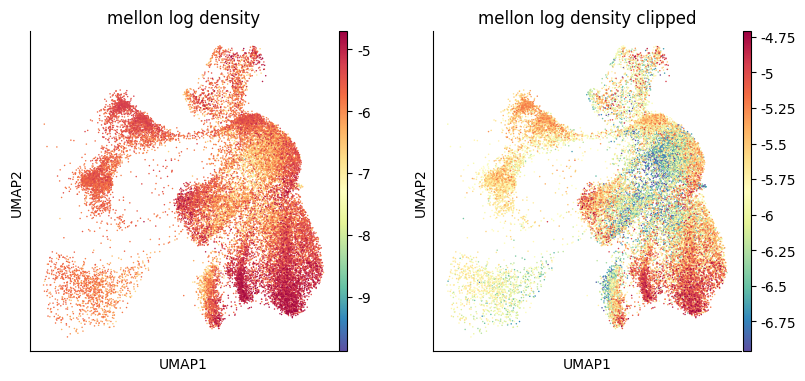

In [167]:
sc.pl.scatter(
    adata, color=["mellon_log_density", "mellon_log_density_clipped"], basis="umap"
)

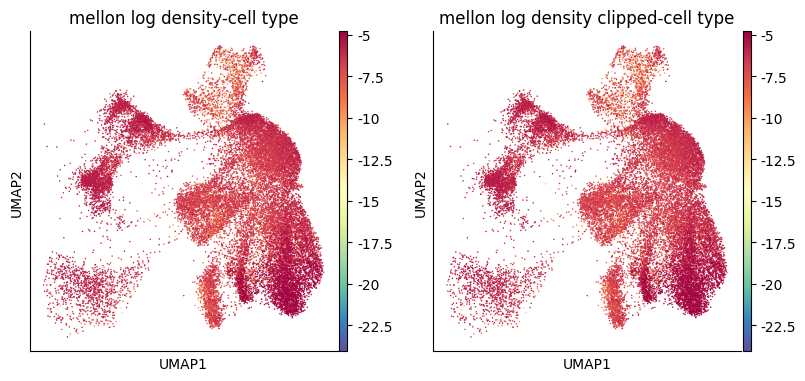

In [170]:
sc.pl.scatter(
    adata, color=["mellon_log_density-cell_type",
                  "mellon_log_density_clipped-cell_type"], basis="umap"
)

In [171]:
xd.show()

## Density estimation with gaussian kernel density estimator

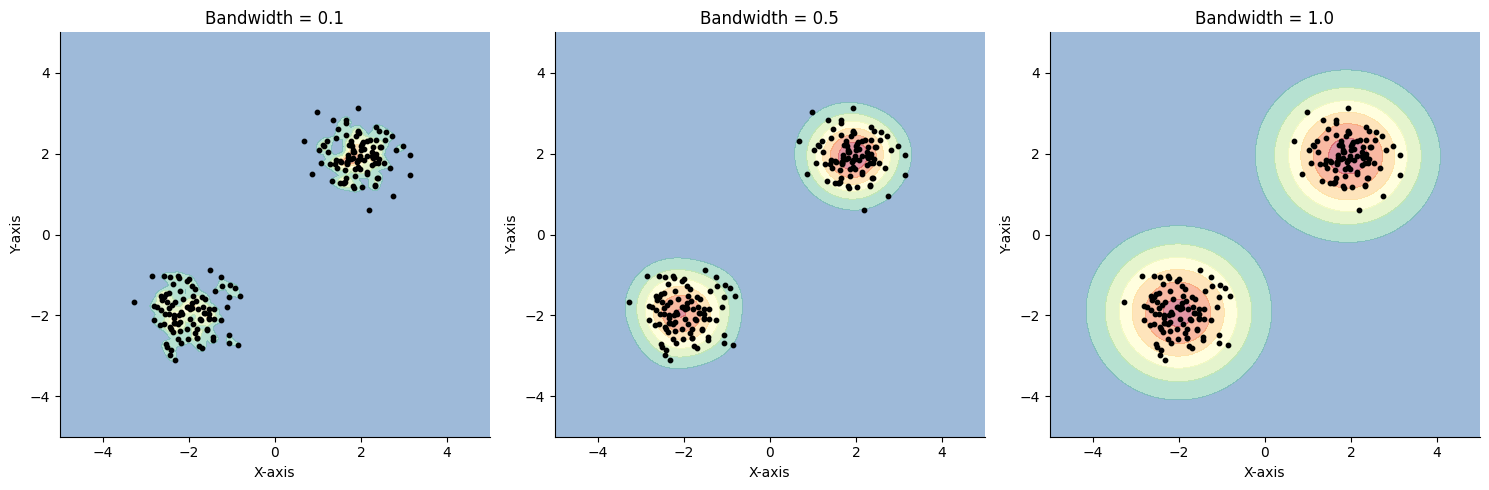

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Generate 2-dimensional bimodal data
np.random.seed(0)
X1 = np.random.normal(loc=[-2, -2], scale=0.5, size=(100, 2))
X2 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))
X = np.vstack([X1, X2])

# Define different bandwidths to illustrate
bandwidths = [0.1, 0.5, 1.0]

# Plot the data and the estimated density for different bandwidths
plt.figure(figsize=(15, 5))

for i, bandwidth in enumerate(bandwidths):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
    X_plot = np.linspace(-5, 5, 100)
    Y_plot = np.linspace(-5, 5, 100)
    X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
    xy_plot = np.vstack([X_plot.ravel(), Y_plot.ravel()]).T
    log_dens = kde.score_samples(xy_plot).reshape(X_plot.shape)

    plt.subplot(1, len(bandwidths), i + 1)
    plt.contourf(X_plot, Y_plot, np.exp(log_dens), alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='k')
    plt.title(f'Bandwidth = {bandwidth}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

plt.tight_layout()
plt.show()


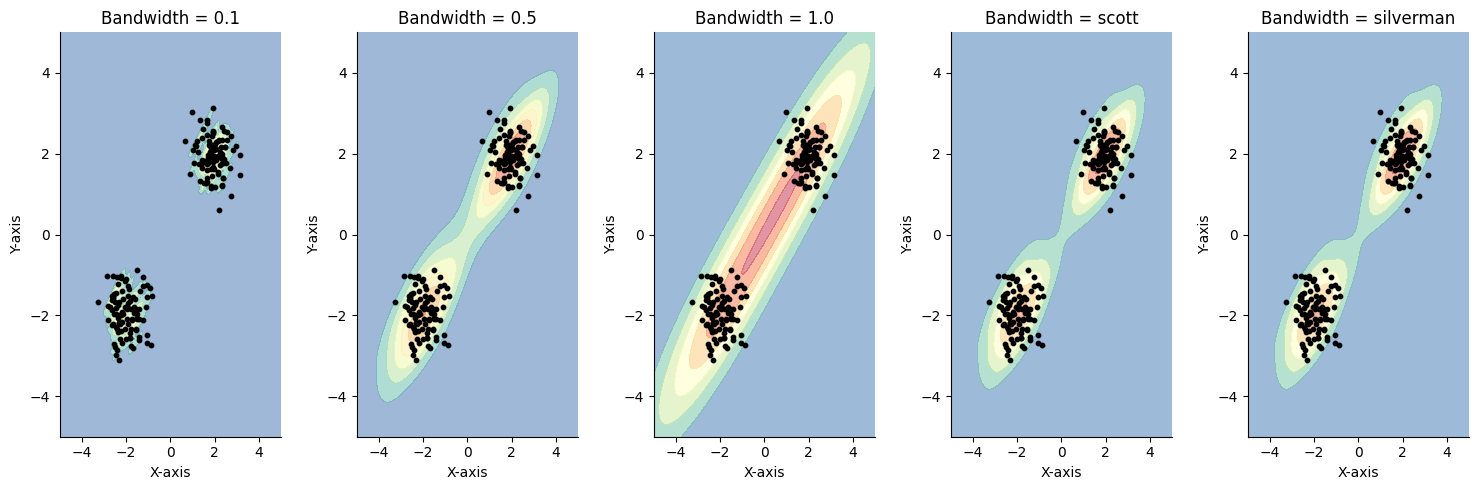

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate 2-dimensional bimodal data
np.random.seed(0)
X1 = np.random.normal(loc=[-2, -2], scale=0.5, size=(100, 2))
X2 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))
X = np.vstack([X1, X2])

# Define different bandwidths to illustrate
bandwidths = [0.1, 0.5, 1.0, "scott", "silverman"]

# Plot the data and the estimated density for different bandwidths
plt.figure(figsize=(15, 5))

for i, bandwidth in enumerate(bandwidths):
    kde = gaussian_kde(X.T, bw_method=bandwidth)
    X_plot = np.linspace(-5, 5, 100)
    Y_plot = np.linspace(-5, 5, 100)
    X_plot, Y_plot = np.meshgrid(X_plot, Y_plot)
    xy_plot = np.vstack([X_plot.ravel(), Y_plot.ravel()])
    z = kde(xy_plot).reshape(X_plot.shape)

    plt.subplot(1, len(bandwidths), i + 1)
    plt.contourf(X_plot, Y_plot, z, alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], s=10, color='k')
    plt.title(f'Bandwidth = {bandwidth}')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')

plt.tight_layout()
plt.show()


In [24]:
# xdcrop = xd.crop(region_tuple=("Tumor", "Selected Tumor"))
# adata = xdcrop.cells.matrix
X = adata.obsm["spatial"]

In [26]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(X.T, bw_method="scott")
z = kde(X.T)

In [31]:
np.array(density)

array([-5.92029771, -5.85116735, -5.77614703, ..., -6.80762604,
       -6.49206908, -6.72040832])

In [27]:
z

array([9.26164024e-08, 9.81777468e-08, 9.95228695e-08, ...,
       8.18191557e-08, 1.04263358e-07, 9.50870660e-08])

In [58]:
# import numpy as np

# def shifted_log_transform(data, base='natural'):
#     """
#     Shifts the data to a minimum of 1 and applies log transformation.

#     Parameters:
#     data (array-like): The input data to be transformed.
#     base (str): The base of the logarithm to use ('natural' for ln, 'log10' for log base 10).

#     Returns:
#     array-like: The log-transformed data.
#     """
#     # Convert data to a numpy array
#     data = np.array(data)

#     # Determine the shift value to make the minimum value 1
#     shift_value = 1 - np.min(data)

#     # Shift the data
#     shifted_data = data + shift_value

#     # Apply the log transformation
#     if base == 'natural':
#         log_transformed_data = np.log(shifted_data)
#     elif base == 'log10':
#         log_transformed_data = np.log10(shifted_data)
#     else:
#         raise ValueError("Invalid base. Use 'natural' for ln or 'log10' for log base 10.")

#     return log_transformed_data


In [59]:
xdcrop.cells.matrix.obs["pdf"] = z
#xdcrop.cells.matrix.obs["log_pdf"] = shifted_log_transform(z)
xdcrop.cells.matrix.obs["log_pdf"] = np.log(z)

In [61]:
xdcrop.show()

In [64]:
adata.obsm["distance_from"]["Tumor cells"]

4305       422.501987
4306       411.973464
4307       412.600541
4308       404.900340
4309       396.483690
             ...     
118570     992.510369
118571    1011.647030
118572    1006.581528
118575     984.114352
118576    1009.791063
Name: Tumor cells, Length: 25443, dtype: float64

In [65]:
adata.obs

transcript_counts  control_probe_counts  control_codeword_counts  \
4305                  315                     0                        0   
4306                  348                     0                        0   
4307                  117                     0                        0   
4308                  165                     0                        0   
4309                  335                     0                        0   
...                   ...                   ...                      ...   
118570                216                     0                        0   
118571                202                     1                        0   
118572                189                     0                        0   
118575                220                     1                        0   
118576                243                     1                        0   

        total_counts   cell_area  nucleus_area  n_genes leiden  \
4305             315  256.668125     65.702344       85      0   
4306             348  143.822656    104.446406       75      0   
4307             117  125.353750     19.642969       49      5   
4308             165  180.173438     32.015781       57      0   
4309             335  187.262969     49.355781       82      0   
...              ...         ...           ...      ...    ...   
118570           216  326.570000     29.035469       72      4   
118571           203  482.810625     24.068281       86      7   
118572           189  353.889531     11.334219       75      9   
118575           221  325.079844     17.565781       73      1   
118576           244  532.572813     29.035469      100      1   

       annotations-TestKey annotations-demo annotations-demo2  \
4305                   NaN              NaN               NaN   
4306                   NaN              NaN               NaN   
4307                   NaN              NaN               NaN   
4308                   NaN              NaN               NaN   
4309                   NaN              NaN               NaN   
...                    ...              ...               ...   
118570                 NaN              NaN               NaN   
118571                 NaN              NaN               NaN   
118572                 NaN              NaN               NaN   
118575                 NaN              NaN               NaN   
118576                 NaN              NaN               NaN   

       annotations-demo3      cell_type  mellon_log_density  \
4305                 NaN  Breast cancer           -5.920541   
4306                 NaN  Breast cancer           -5.851231   
4307                 NaN  Breast cancer           -5.776279   
4308                 NaN  Breast cancer           -5.680696   
4309                 NaN  Breast cancer           -5.641874   
...                  ...            ...                 ...   
118570               NaN    Fibroblasts           -6.609508   
118571               NaN    Macrophages           -6.833602   
118572               NaN    Fibroblasts           -6.806839   
118575               NaN    Fibroblasts           -6.491334   
118576               NaN    Fibroblasts           -6.719707   

        mellon_log_density_clipped           pdf    log_pdf  
4305                     -5.920541  9.261640e-08 -16.194800  
4306                     -5.851231  9.817775e-08 -16.136486  
4307                     -5.776279  9.952287e-08 -16.122878  
4308                     -5.680696  1.048174e-07 -16.071046  
4309                     -5.641874  1.096501e-07 -16.025971  
...                            ...           ...        ...  
118570                   -6.609508  9.251287e-08 -16.195918  
118571                   -6.833602  8.519834e-08 -16.278284  
118572                   -6.806839  8.181916e-08 -16.318754  
118575                   -6.491334  1.042634e-07 -16.076346  
118576                   -6.719707  9.508707e-08 -16.168473  

[25443 rows x 17 co

In [70]:
from insitupy import CustomPalettes

In [75]:
from insitupy._constants import DEFAULT_CATEGORICAL_CMAP

In [80]:
DEFAULT_CATEGORICAL_CMAP.colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#17becf',
 '#aec7e8',
 '#ffbb78',
 '#98df8a',
 '#ff9896',
 '#c5b0d5',
 '#c49c94',
 '#f7b6d2',
 '#dbdb8d',
 '#9edae5',
 '#7f7f7f',
 '#c7c7c7']

In [86]:
adata.obs["leiden"].values.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15'],
      dtype='object')

{'0': '#1f77b4',
 '1': '#ff7f0e',
 '2': '#2ca02c',
 '3': '#d62728',
 '4': '#9467bd',
 '5': '#8c564b',
 '6': '#e377c2',
 '7': '#bcbd22',
 '8': '#17becf',
 '9': '#aec7e8',
 '10': '#ffbb78',
 '11': '#98df8a',
 '12': '#ff9896',
 '13': '#c5b0d5',
 '14': '#c49c94',
 '15': '#f7b6d2'}

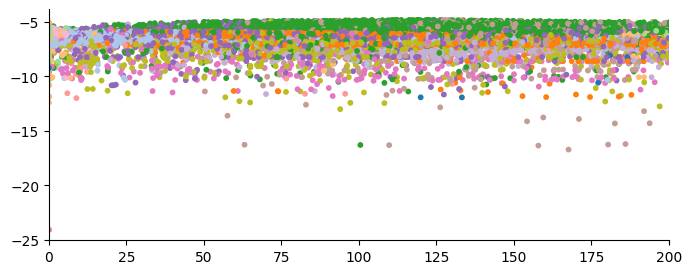

In [173]:
import pandas as pd

color_dict = dict(zip(adata.obs["leiden"].values.categories, DEFAULT_CATEGORICAL_CMAP.colors))

plt.figure(figsize=[8, 3])
plt.scatter(
    adata.obsm["distance_from"]["Tumor cells"],
    adata.obs["mellon_log_density_clipped-cell_type"],
    s=10,
    color=[color_dict[elem] for elem in adata.obs["leiden"]]
)

plt.xlim(0, 200)
plt.show()

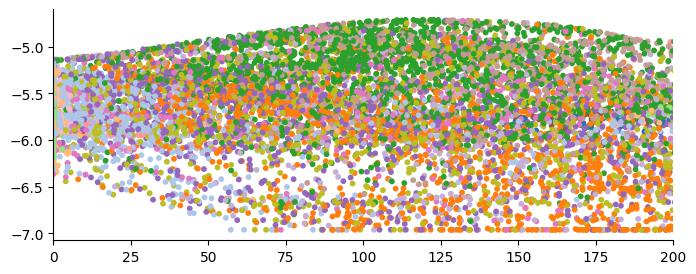

In [ ]:
import pandas as pd

color_dict = dict(zip(adata.obs["leiden"].values.categories, DEFAULT_CATEGORICAL_CMAP.colors))

plt.figure(figsize=[8, 3])
plt.scatter(
    adata.obsm["distance_from"]["Tumor cells"],
    adata.obs["mellon_log_density_clipped"],
    s=10,
    color=[color_dict[elem] for elem in adata.obs["leiden"]]
)

plt.xlim(0, 200)
plt.show()

In [91]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_scatter(adata,
                 axis_key,
                 density_key,
                 hue,
                 cmap = DEFAULT_CATEGORICAL_CMAP
                 ):
    # Create a dictionary mapping categories to colors
    color_dict = dict(zip(adata.obs[hue].values.categories, cmap.colors))

    # Create the plot
    plt.figure(figsize=[8, 3])
    plt.scatter(
        adata.obsm[axis_key[0]][axis_key[1]],
        adata.obs[density_key],
        s=10,
        color=[color_dict[elem] for elem in adata.obs[hue]]
    )

    # Set x-axis limits
    plt.xlim(0, 200)

    # Create custom legend
    legend_patches = [mpatches.Patch(color=color, label=category) for category, color in color_dict.items()]
    plt.legend(handles=legend_patches, title="Categories")

    # Show the plot
    plt.show()

# Example usage
# plot_scatter(adata, DEFAULT_CATEGORICAL_CMAP, "distance_from", "Tumor cells", "leiden", "mellon_log_density")


In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_scatter(adata,
                 axis_key,
                 density_key,
                 hue,
                 categories_to_include=None,
                 xlim=None,
                 ylim=None,
                 cmap=DEFAULT_CATEGORICAL_CMAP):
    # Create a dictionary mapping categories to colors
    color_dict = dict(zip(adata.obs[hue].values.categories, cmap.colors))

    # Create a DataFrame from the relevant data
    df = pd.DataFrame({
        'x': adata.obsm[axis_key[0]][axis_key[1]],
        'y': adata.obs[density_key],
        'hue': adata.obs[hue].tolist()
    })

    # Filter the DataFrame to include only specified categories
    if categories_to_include is not None:
        df = df[df['hue'].isin(categories_to_include)]

    # apply limits
    if xlim is not None:
        xmask = (df['x'] >= xlim[0]) & (df['x'] <= xlim[1])
    else:
        xmask = [True] * len(df)
    if ylim is not None:
        ymask = (df['y'] >= ylim[0]) & (df['y'] <= ylim[1])
    else:
        ymask = [True] * len(df)
    df = df[xmask & ymask]

    # Create the plot
    plt.figure(figsize=[8, 3])
    scatter_plot = sns.scatterplot(
        data=df,
        x='x',
        y='y',
        hue='hue',
        palette=color_dict,
        s=10
    )

    #return df

    # if xlim is not None:
    #     # Set x-axis limits
    #     plt.xlim([xlim[0], xlim[1]])

    # if ylim is not None:
    #     # Set y-axis limits
    #     plt.ylim([ylim[0], ylim[1]])

    # Move the default legend outside the plot
    scatter_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()


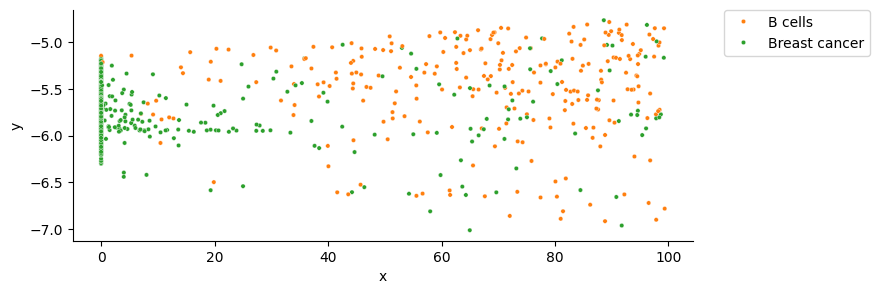

In [186]:

# Example usage
df = plot_scatter(adata,
             axis_key=["distance_from", "Tumor cells"],
             density_key="mellon_log_density",
             hue="cell_type",
             categories_to_include=['Breast cancer', 'B cells'],
             xlim=(0,100)
             )


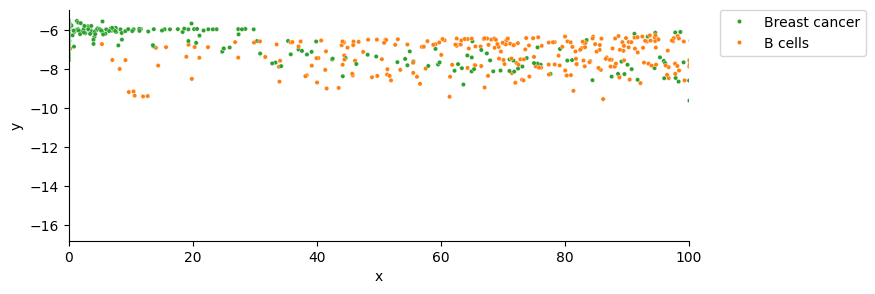

In [177]:

# Example usage
df = plot_scatter(adata,
             axis_key=["distance_from", "Tumor cells"],
             density_key="mellon_log_density-cell_type",
             hue="cell_type",
             categories_to_include=['Breast cancer', 'B cells'],
             xlim=(0,100)
             )


## The kernel density has to be calculated seperately for each cell_type or not?!

In [127]:
adata.obs["cell_type"].cat.categories

Index(['Adipocytes', 'B cells', 'Breast cancer', 'Breast glandular cells',
       'Breast myoepithelial cells', 'Dendritic cells', 'Endothelial cells',
       'Epithelial cells', 'Fibroblasts', 'Macrophages', 'Mast cells',
       'Monocytes', 'Myeloid cells', 'NK cells', 'Neutrophils', 'Plasma cells',
       'Smooth muscle cells', 'T cells'],
      dtype='object')

In [122]:
df.hue.tolist()

['Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Macrophages',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibroblasts',
 'Fibrob

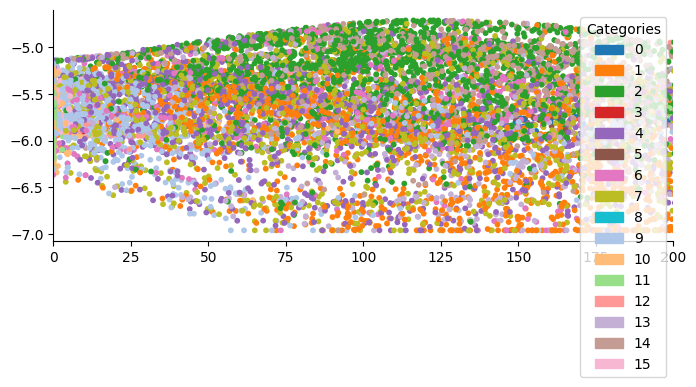

In [94]:
plot_scatter(
    adata=adata,
    axis_key=("distance_from", "Tumor cells"),
    density_key="mellon_log_density_clipped",
    hue="leiden"
)

In [69]:
adata.obs["leiden"]

4305      0
4306      0
4307      5
4308      0
4309      0
         ..
118570    4
118571    7
118572    9
118575    1
118576    1
Name: leiden, Length: 25443, dtype: category
Categories (16, object): ['0', '1', '2', '3', ..., '12', '13', '14', '15']

In [68]:
palantir.plot.plot_branch(
    adata,
    #branch_name="NaiveB",
    position="mellon_log_density",
    color="leiden",
    #masks_key="palantir_lineage_cells",
    s=100,
)
plt.show()

TypeError: plot_branch() missing 1 required positional argument: 'branch_name'

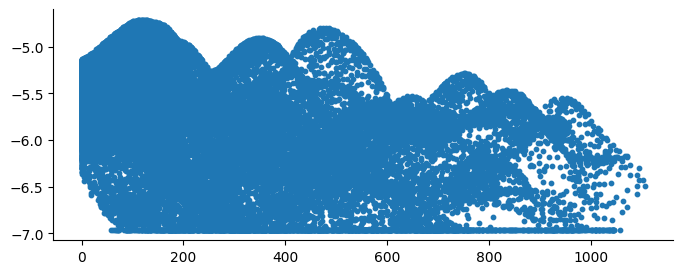

In [67]:
import pandas as pd

ct_colors = pd.Series(
    adata.uns["celltype_colors"], index=adata.obs["celltype"].values.categories
)

plt.figure(figsize=[8, 3])
plt.scatter(
    adata.obsm["distance_from"]["Tumor cells"],
    adata.obs["mellon_log_density_clipped"],
    s=10,
    #color=ct_colors[ad.obs["celltype"][bcell_lineage_cells]],
)
plt.show()

In [127]:

xdcrop.cells.matrix.obs["log_pdf"].min()

0.0

In [129]:
xdcrop.cells.matrix.obs["pdf"].min()

4.826019679125634e-09

In [128]:
xdcrop.cells.matrix.obs["log_pdf"].max()

4.3449900208526267e-07

In [130]:
xdcrop.cells.matrix.obs["pdf"].max()

4.393251160860985e-07

In [126]:
xdcrop.show()

In [116]:
z.min()

4.826019679125634e-09

In [117]:
z.max()

4.393251160860985e-07

In [114]:
xdcrop.show()

In [107]:
z.min()

4.826019679125634e-09

In [108]:
z.max()

4.393251160860985e-07

In [109]:
np.log(0.001)

-6.907755278982137

In [105]:
np.log(z).min()

-19.14924379202175

In [106]:
np.log(z).max()

-14.63802611462813

In [103]:
xdcrop.show()

In [99]:
np.log(z)

array([-16.19479958, -16.13648626, -16.12287838, ..., -16.31875444,
       -16.07634585, -16.16847288])

In [52]:
kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(X)
log_dens = kde.score_samples(X)

In [54]:
log_dens

array([-13.84284281, -13.84284281, -13.84284281, ..., -13.84284281,
       -13.84284281, -13.84284281])

In [55]:
log_dens.min()

-13.84284281024215

In [56]:
log_dens.max()

-13.808931533478317

In [49]:
log_dens.size

10000

In [30]:
X

array([[-1.11797383],
       [-1.7999214 ],
       [-1.51063101],
       [-0.8795534 ],
       [-1.066221  ],
       [-2.48863894],
       [-1.52495579],
       [-2.0756786 ],
       [-2.05160943],
       [-1.79470075],
       [-1.92797821],
       [-1.27286325],
       [-1.61948114],
       [-1.93916249],
       [-1.77806838],
       [-1.83316284],
       [-1.25296046],
       [-2.10257913],
       [-1.84346615],
       [-2.42704787],
       [-3.27649491],
       [-1.6731907 ],
       [-1.5677819 ],
       [-2.37108251],
       [-0.86512269],
       [-2.72718284],
       [-1.97712074],
       [-2.09359193],
       [-1.23361039],
       [-1.26532062],
       [-1.92252629],
       [-1.81091874],
       [-2.44389287],
       [-2.99039823],
       [-2.17395607],
       [-1.92182552],
       [-1.38485466],
       [-1.39881008],
       [-2.19366341],
       [-2.15115138],
       [-2.52427648],
       [-2.71000897],
       [-2.8531351 ],
       [-1.0246123 ],
       [-2.25482609],
       [-2

## Plot gene expression along axis

In [17]:
from insitupy.plotting import expr_along_obs_val, cell_abundance_along_obs_val

Retrieve `obs_val` from .obsm.
Key 'CD8' not found.
Saving figure to file out/expr_along_axis.pdf
Saved.


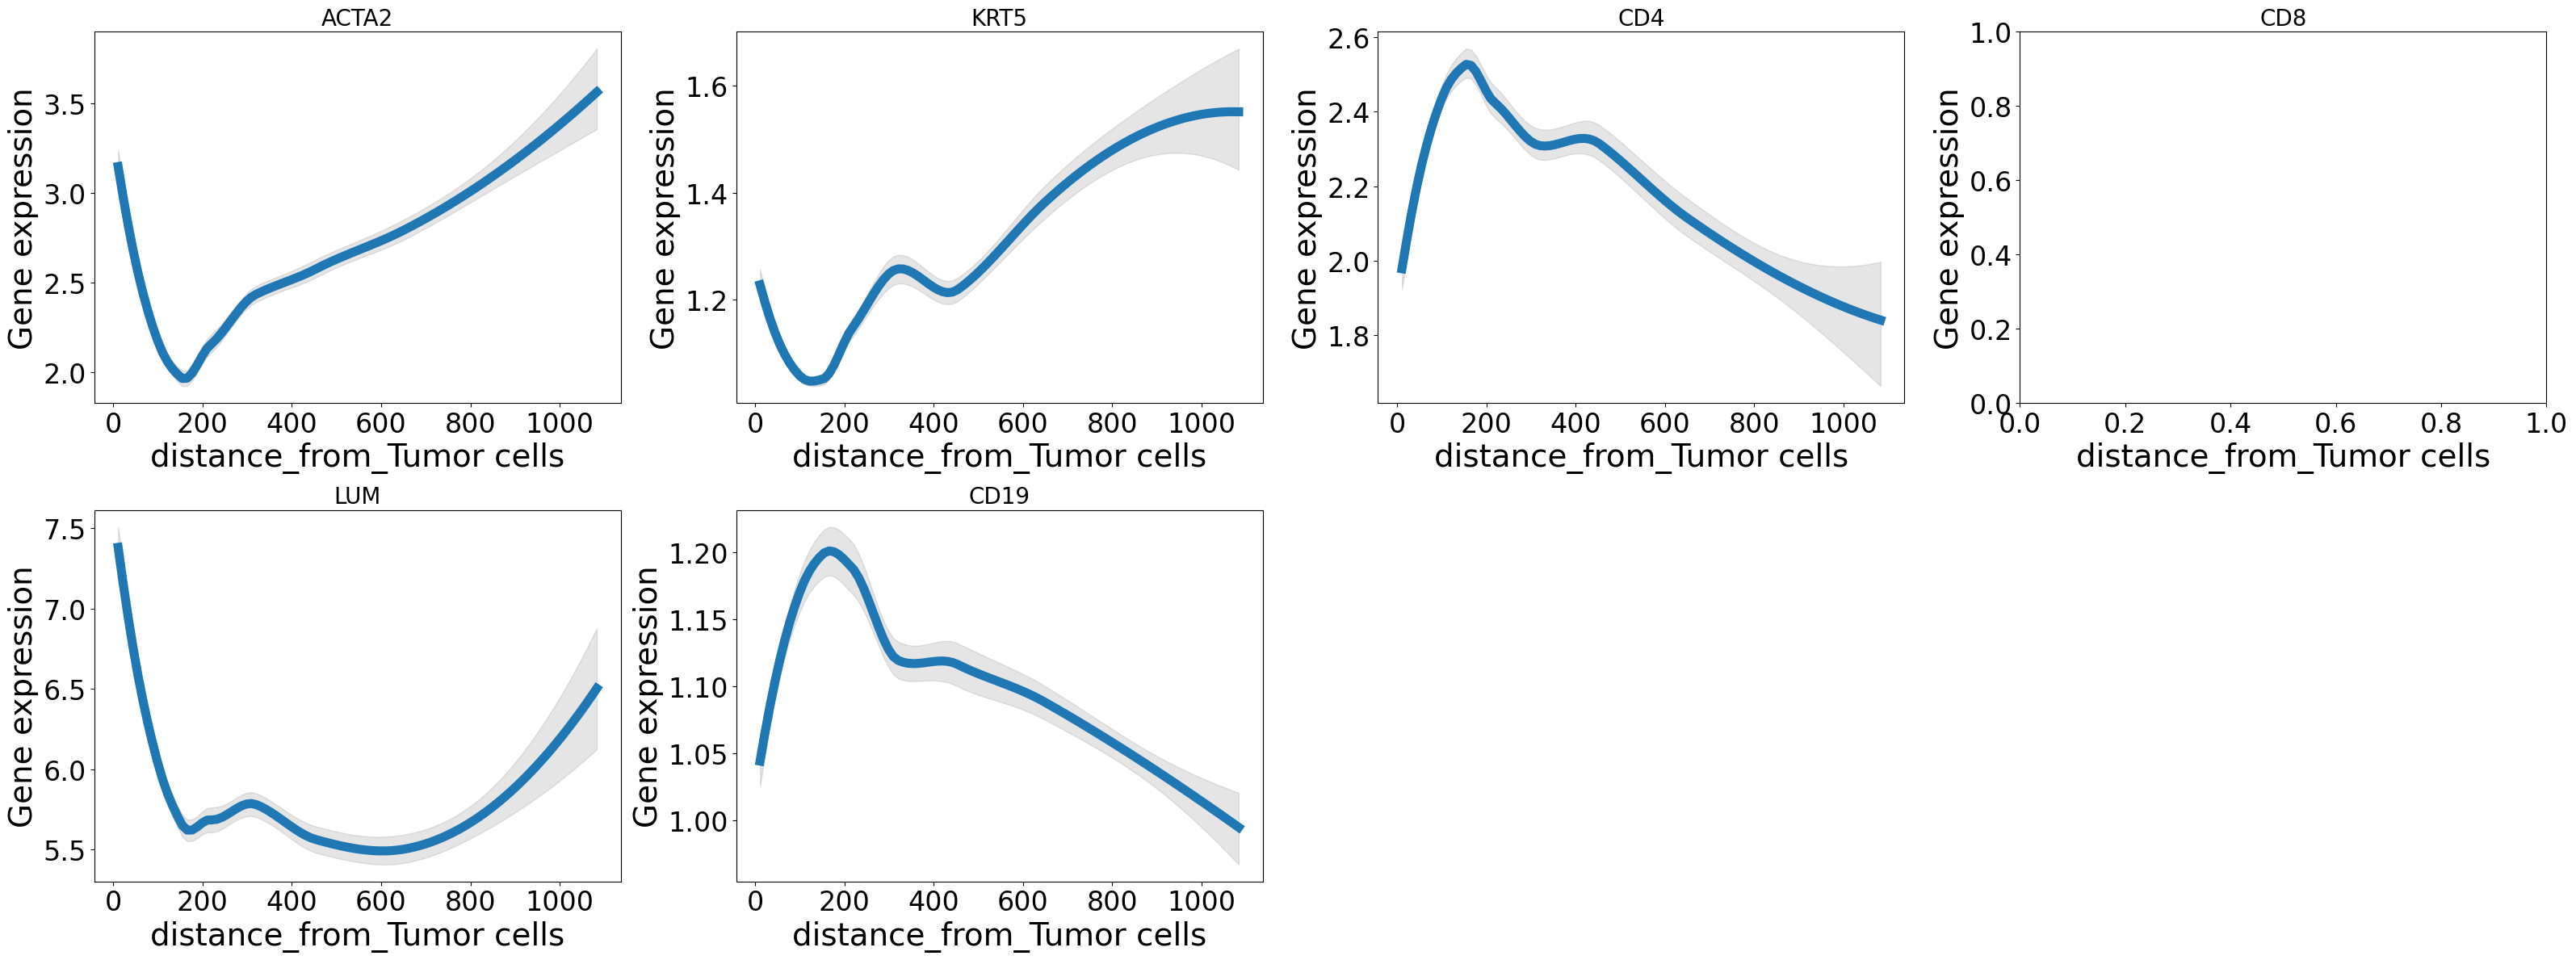

In [18]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=["ACTA2", "KRT5", "CD4", "CD8", "LUM", "CD19"],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   savepath="out/expr_along_axis.pdf"
                   )

## Plot abundance of cell types along axis

Retrieve `obs_val` from .obsm.


C:\Users\ge37voy\Github\InSituPy\insitupy\plotting\expression_along_axis.py:468: UserWarning: The palette list has more values (20) than needed (18), which may not be intended.
  h = sns.histplot(data=data, x=obs_val,


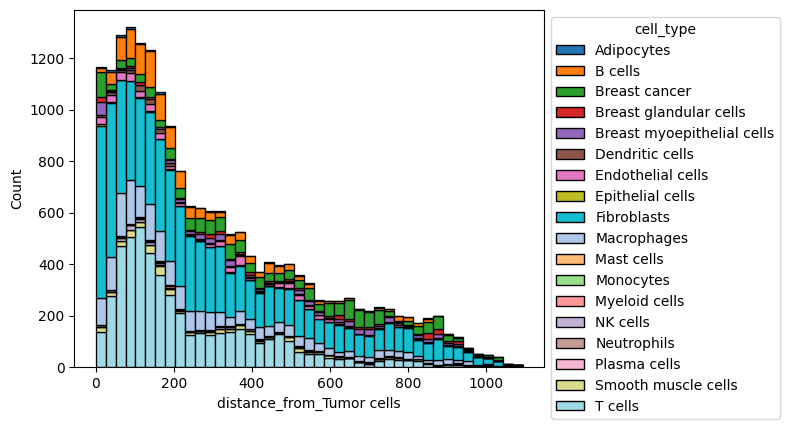

In [19]:
cell_abundance_along_obs_val(
    adata=xd.cells.matrix,
    obs_val=("distance_from", "Tumor cells"),
    groupby="cell_type",
    figsize=(8,4.5)
)

# How can we identify significant patterns?

In the SPATA2 paper they work with a metric they call total variation (TV):
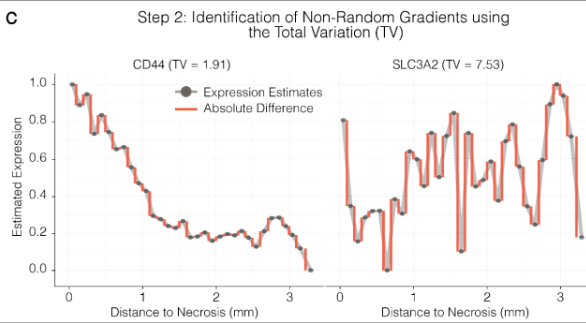
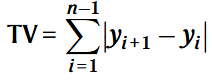

And the significance of a pattern they calculate with following formular:
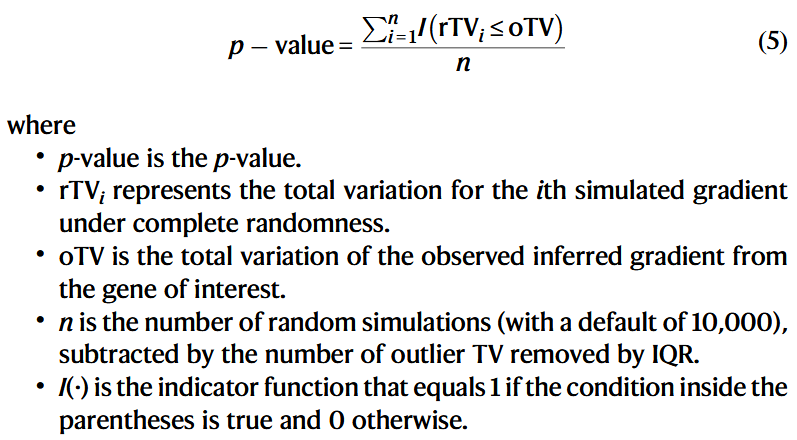

## Using SPATA2 method

In [20]:
import numpy as np

In [21]:
_adata = xd.cells.matrix

In [22]:
_adata

AnnData object with n_obs × n_vars = 163565 × 313
    obs: 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_genes', 'leiden', 'annotations-TestKey', 'annotations-demo', 'annotations-demo2', 'annotations-demo3', 'cell_type'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'cell_type_colors', 'counts_location', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'OT', 'X_pca', 'X_umap', 'spatial', 'regions', 'distance_from'
    varm: 'OT', 'PCs', 'binned_expression'
    layers: 'counts', 'norm_counts'
    obsp: 'connectivities', 'distances'

In [23]:
# Functions
def total_variation(values):
    return np.sum(np.abs(np.diff(values)))

def random_permutation_tv(expr):
    # Create an array with values from 0 to 10
    random_order = np.random.permutation(np.arange(len(expr)))
    expr_sorted = expr[random_order]

    return total_variation(expr_sorted)

def random_permutation_tv_precalc(expr, permutations):
    expr_sorted = expr[permutations]
    return total_variation(expr_sorted)

def filter_outliers(data, threshold=1.5):
    """
    Remove values that lie significantly outside the IQR.

    Args:
        data (numpy.ndarray): The input array.
        threshold (float, optional): The multiplier for the IQR to define outliers. Default is 1.5.

    Returns:
        numpy.ndarray: The filtered array with outliers removed.
    """
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)

    # Calculate the IQR
    IQR = Q3 - Q1

    # Calculate the lower and upper bounds
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    # Filter the array to remove outliers
    filtered_data = data[(data >= lower_bound) & (data <= upper_bound)]

    return filtered_data



In [24]:
from tqdm import tqdm
from joblib import delayed, Parallel

In [39]:
def calculate_total_variation_pval(adata, gene, parallel, n_sim: int = 10000):
    dists = adata.obsm["distance_from"]["Tumor cells"].values
    notna_mask = ~np.isnan(dists)
    notzero_mask = dists > 0
    gene_loc = adata.var_names.get_loc(gene)
    expr = adata.X[:, gene_loc]
    expr = expr[notna_mask & notzero_mask].T.toarray()[0]
    dists = dists[notna_mask & notzero_mask]
    expr_sorted = expr[np.argsort(dists)]

    tv_gene = total_variation(values=expr_sorted)
    # simulation of random total variations
    # speed up computation with joblib
    if parallel:
        random_tvs = np.array(Parallel(n_jobs=8)(delayed(random_permutation_tv)(expr) for _ in range(n_sim)))
    else:
        random_tvs = np.array([random_permutation_tv(expr) for _ in range(n_sim)])
    random_tvs_filtered = filter_outliers(random_tvs)
    n = len(random_tvs_filtered)
    p_val = np.sum(random_tvs_filtered <= tv_gene) / n
    return p_val


In [41]:
pval = calculate_total_variation_pval(adata=_adata, gene="ACTG2", parallel=True, n_sim=1000)

In [42]:
pval

0.0

In [43]:
genes = _adata.var_names.tolist()

In [44]:
from tqdm.auto import tqdm

In [45]:
def run1(genes):
    return np.array([calculate_total_variation_pval(adata=_adata, gene=gene, parallel=True, n_sim=1000) for gene in tqdm(genes)])

def run2(genes):
    return np.array(Parallel(n_jobs=16)(delayed(calculate_total_variation_pval)(_adata, gene, False, 1000) for gene in tqdm(genes)))

In [46]:
pvals = run2(genes)

  0%|          | 0/313 [00:00<?, ?it/s]

## In the SPATA2 paper they use Benjamini-Hochberg to adjust the p-value and get the FDR

In [47]:
import matplotlib.pyplot as plt

In [48]:
not_significant_genes = np.array(genes)[pvals > 0.05]
significant_genes = np.array(genes)[pvals <= 0.05]

Retrieve `obs_val` from .obsm.


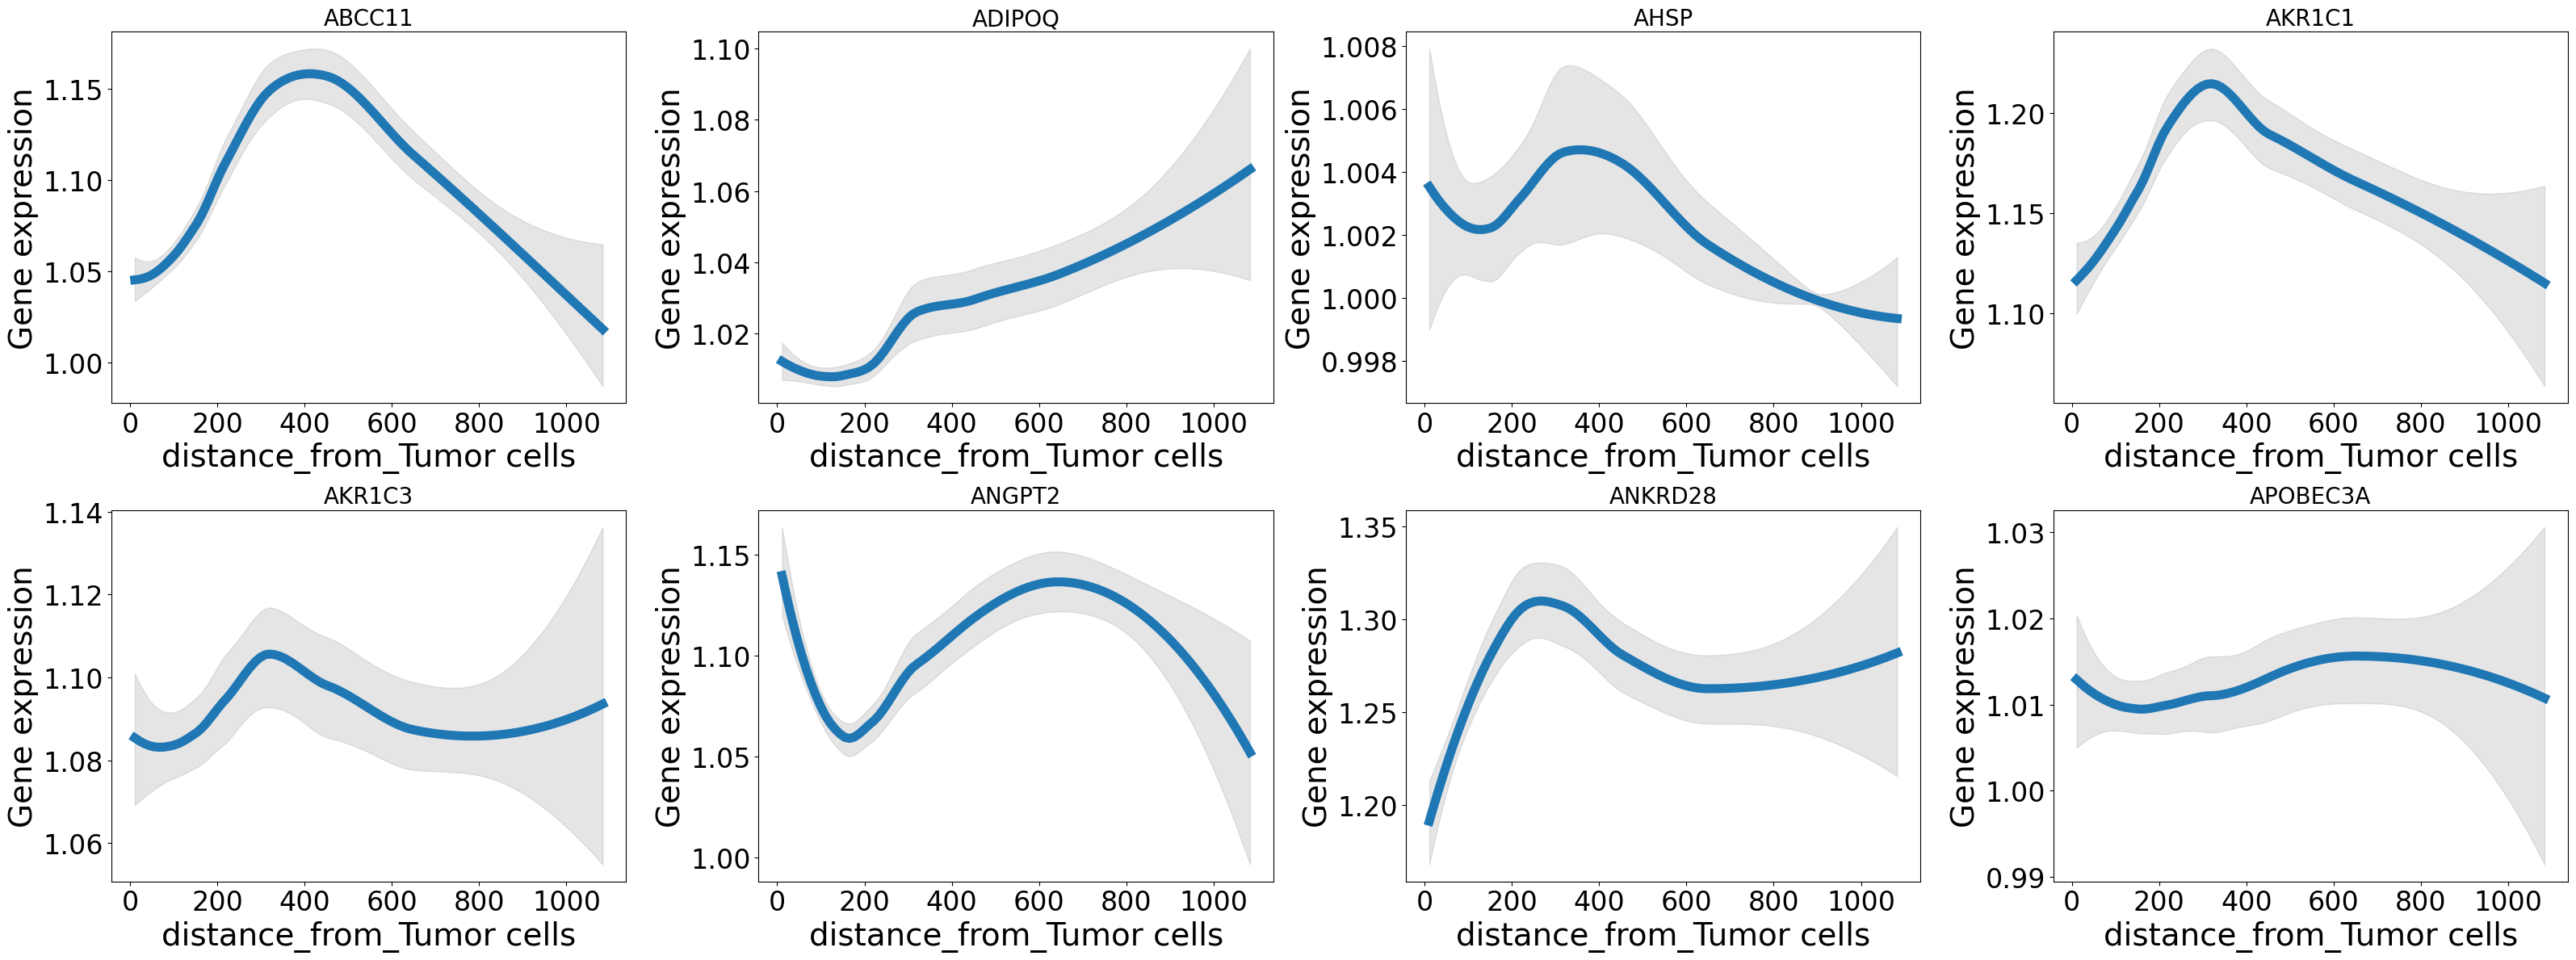

In [49]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=not_significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

Retrieve `obs_val` from .obsm.


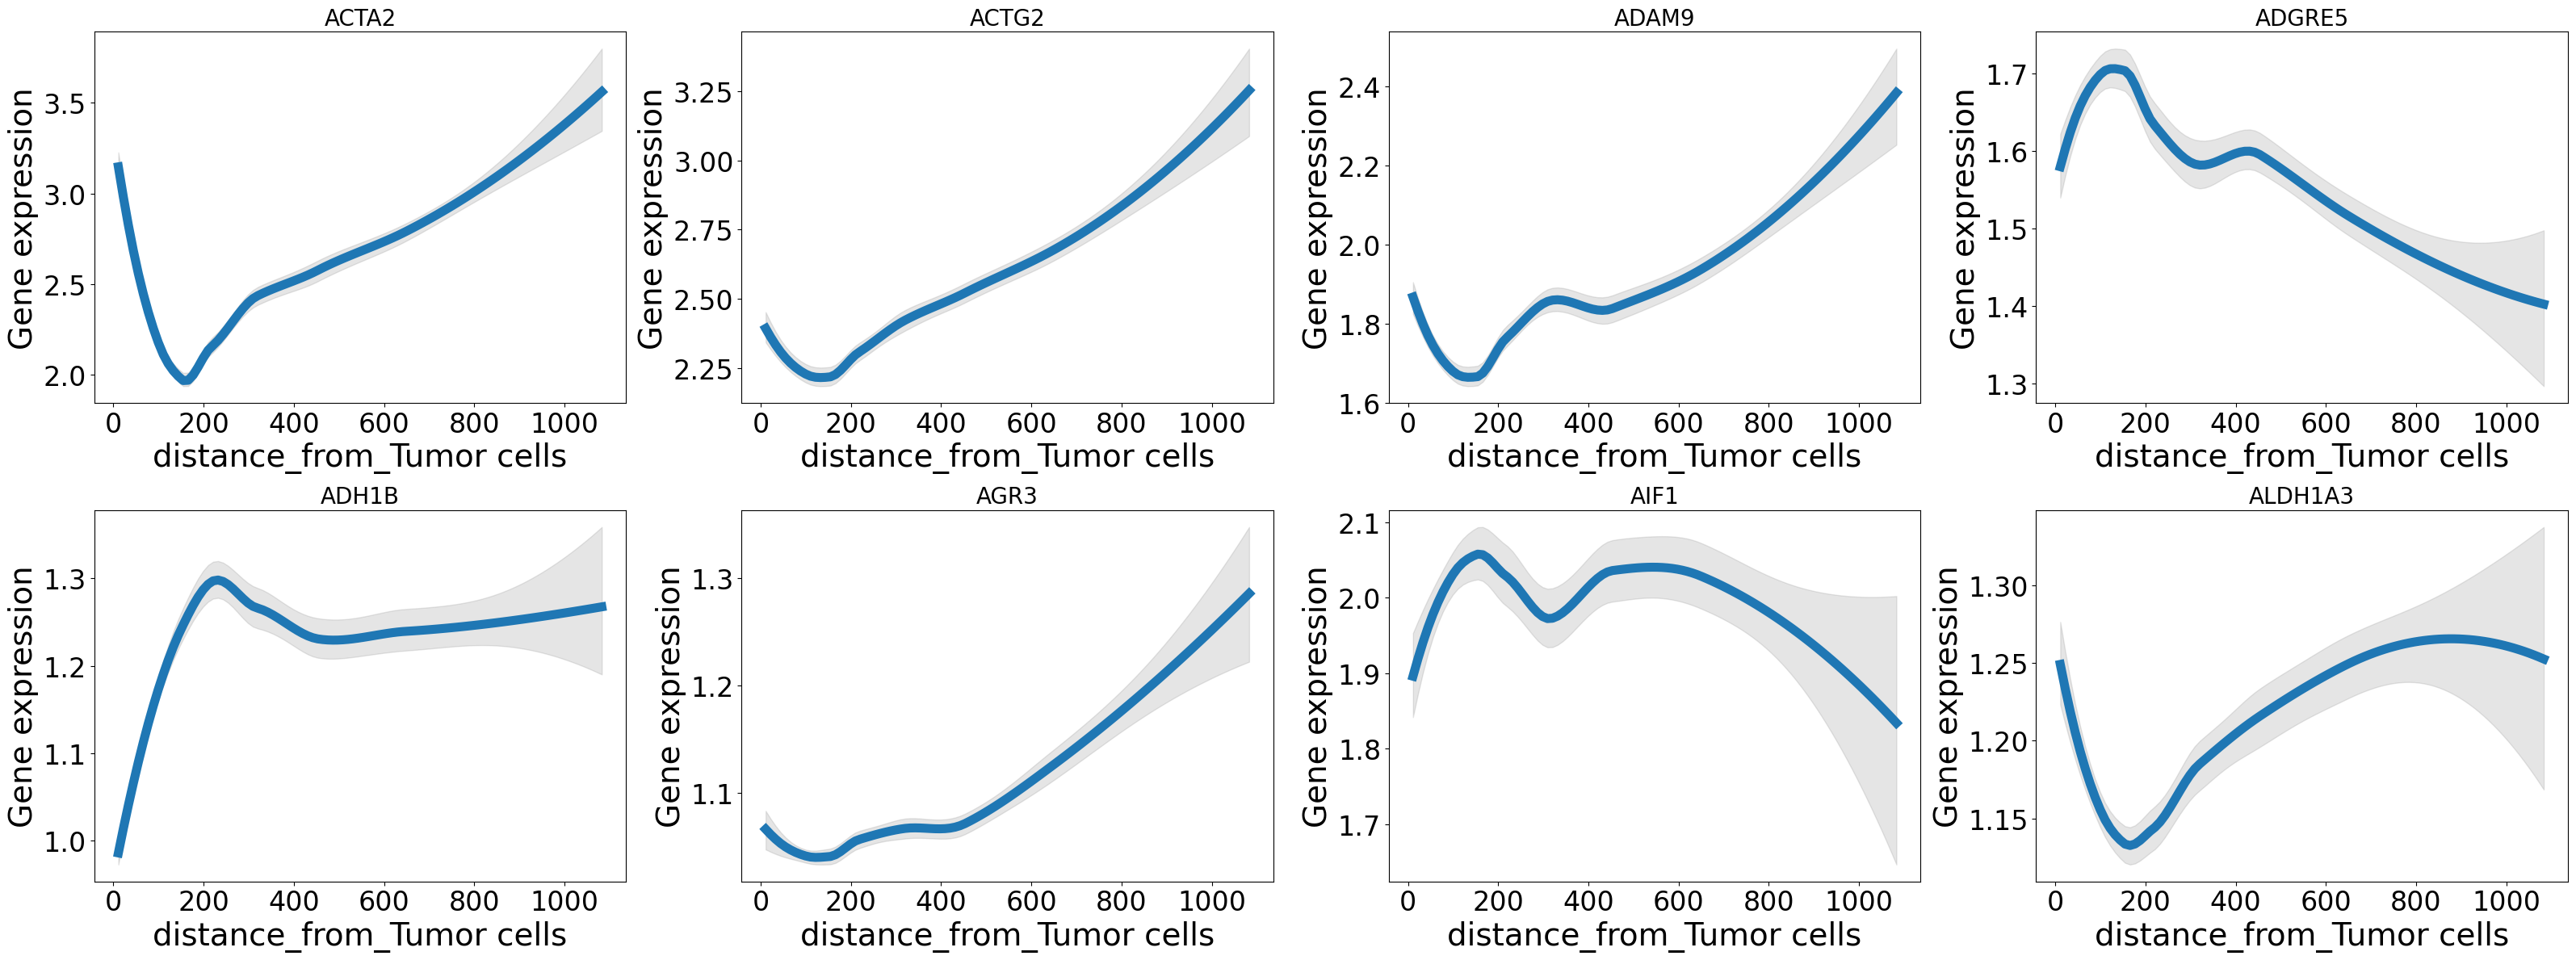

In [50]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

In [51]:
calculate_total_variation_pval(_adata, "AIF1", True)

0.027242457875088284

## Use autocorrelation to select genes

Ljung-Box Test: This is often considered one of the most powerful tests for detecting autocorrelation in time series data, especially when testing multiple lags simultaneously. It is widely used in practice and is robust for various sample sizes.

In [52]:
import statsmodels.api as sm

#load data series
data = sm.datasets.sunspots.load_pandas().data

#view first ten rows of data series
data[:5]

YEAR  SUNACTIVITY
0  1700.0          5.0
1  1701.0         11.0
2  1702.0         16.0
3  1703.0         23.0
4  1704.0         36.0

In [54]:
from statsmodels.tsa.arima.model import ARIMA

In [55]:
#fit ARMA model to dataset
res = ARIMA(data["SUNACTIVITY"], (1,1)).fit(disp=-1)

#perform Ljung-Box test on residuals with lag=5
sm.stats.acorr_ljungbox(res.resid, lags=[5], return_df=True)

ValueError: A constant trend was included in the model specification, but the `exog` data already contains a column of constants.

## Clustering of patterns

In [56]:
df = expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes,
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=False, return_data=True)

Retrieve `obs_val` from .obsm.


In [58]:
df = expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes,
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True, return_data=True)

Retrieve `obs_val` from .obsm.


In [57]:
df

x    y_pred    std
key                                         
ACTA2  None 0     11.094653  3.146789  False
            1     22.145508  2.980164  False
            2     33.196363  2.825612  False
            3     44.247218  2.684409  False
            4     55.298073  2.557813  False
...                     ...       ...    ...
ZNF562 None 93  1038.824168  1.628803  False
            94  1049.875023  1.631820  False
            95  1060.925878  1.634814  False
            96  1071.976733  1.637786  False
            97  1083.027588  1.640736  False

[15092 rows x 3 columns]

In [176]:
# reshape and rename dataframe
df.index = df.index.droplevel(1)
df.index.names = ["gene", "pos"]

In [177]:
df

x    y_pred    std
gene   pos                              
ACTA2  0      11.094653  3.146789  False
       1      22.145508  2.980164  False
       2      33.196363  2.825612  False
       3      44.247218  2.684409  False
       4      55.298073  2.557813  False
...                 ...       ...    ...
ZNF562 93   1038.824168  1.628803  False
       94   1049.875023  1.631820  False
       95   1060.925878  1.634814  False
       96   1071.976733  1.637786  False
       97   1083.027588  1.640736  False

[22736 rows x 3 columns]

### Reshape data

In [178]:
import pandas as pd

In [179]:
regpivot = pd.pivot(df.reset_index(), index="pos", columns="gene", values="y_pred")

In [180]:
regpivot

gene     ACTA2     ACTG2     ADAM9    ADGRE5     ADH1B      AGR3      AIF1  \
pos                                                                          
0     3.146789  2.392529  1.867334  1.579889  0.985708  1.066525  1.896092   
1     2.980164  2.361282  1.831587  1.603033  1.013595  1.061637  1.919326   
2     2.825612  2.332844  1.799005  1.624068  1.040187  1.057201  1.940829   
3     2.684409  2.307552  1.770062  1.642653  1.065512  1.053298  1.960458   
4     2.557813  2.285739  1.745222  1.658453  1.089595  1.050007  1.978069   
..         ...       ...       ...       ...       ...       ...       ...   
93    3.462884  3.177608  2.325069  1.409733  1.263676  1.267574  1.861779   
94    3.487074  3.196144  2.339624  1.407810  1.264618  1.272105  1.855040   
95    3.511539  3.214915  2.354366  1.405958  1.265569  1.276663  1.848192   
96    3.536278  3.233920  2.369295  1.404179  1.266529  1.281248  1.841234   
97    3.561290  3.253160  2.384411  1.402472  1.267496  1.285860  1.834168   

gene    AKR1C1   ALDH1A3   ANKRD29  ...     TRIB1    TUBA4A    TUBB2B  \
pos                                 ...                                 
0     1.116352  1.249027  1.064281  ...  1.208515  1.696718  1.104494   
1     1.118831  1.233323  1.068488  ...  1.209759  1.699844  1.098039   
2     1.121457  1.218712  1.072504  ...  1.211188  1.702376  1.092116   
3     1.124295  1.205272  1.076289  ...  1.212853  1.704122  1.086776   
4     1.127407  1.193080  1.079798  ...  1.214800  1.704889  1.082071   
..         ...       ...       ...  ...       ...       ...       ...   
93    1.120888  1.257480  1.100289  ...  1.493890  1.620616  1.214126   
94    1.119412  1.256347  1.099460  ...  1.494249  1.618122  1.216212   
95    1.117925  1.255139  1.098621  ...  1.494486  1.615587  1.218291   
96    1.116426  1.253857  1.097774  ...  1.494600  1.613010  1.220362   
97    1.114916  1.252500  1.096918  ...  1.494590  1.610392  1.222426   

gene     USP53     VOPP1       VWF      WARS      ZEB1      ZEB2    ZNF562  
pos                                                                         
0     1.214843  2.043518  1.335813  2.094275  2.218891  3.195398  1.401919  
1     1.222464  2.059973  1.323125  2.044854  2.148555  3.178828  1.392091  
2     1.229918  2.075116  1.311638  1.998333  2.082646  3.162654  1.383184  
3     1.237188  2.088844  1.301245  1.955006  2.021644  3.146866  1.375325  
4     1.244258  2.101057  1.291840  1.915164  1.966022  3.131452  1.368640  
..         ...       ...       ...       ...       ...       ...       ...  
93    1.369184  2.011803  1.255705  1.782269  1.952262  2.611603  1.628803  
94    1.366523  2.013812  1.247406  1.781745  1.961370  2.615232  1.631820  
95    1.363773  2.015966  1.239011  1.781133  1.970652  2.619196  1.634814  
96    1.360933  2.018267  1.230523  1.780433  1.980109  2.623497  1.637786  
97    1.358004  2.020715  1.221942  1.779645  1.989742  2.628134  1.640736  

[98 rows x 232 columns]

## Calculate distance matrix from regression lines

Normalization/Z-scoring necessary to make distance measure independent of expression scale.

In [194]:
from dtaidistance import dtw, clustering
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette
from insitupy import CustomPalettes
import seaborn as sns

### Perform standardization by z-scoring

In [183]:
norm = stats.zscore(regpivot.T, axis=1)

### Choose color palette

In [186]:
cpal = CustomPalettes()

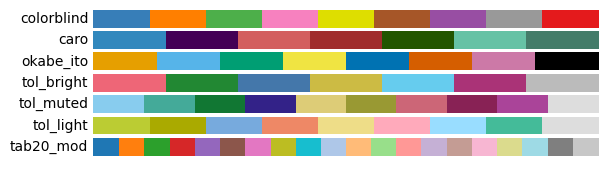

In [187]:
cpal.show_all()

In [188]:
# choose colormap
cmap = cpal.colorblind

### Calculate distance using Dynamic Time Warping and perform hierarchical clustering
https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html

In [189]:
# calculate distance matrix
dm = dtw.distance_matrix(norm.values, use_mp=True, use_c=True)
dm = pd.DataFrame(dm, index=norm.index, columns=norm.index)

### Hierarchical clustering
model = clustering.LinkageTree(dtw.distance_matrix, dists_options={'use_mp': True, 'use_c': True})
cluster_id = model.fit(norm.values)

# get linkage
Z = model.linkage

### Select distance threshold for clustering

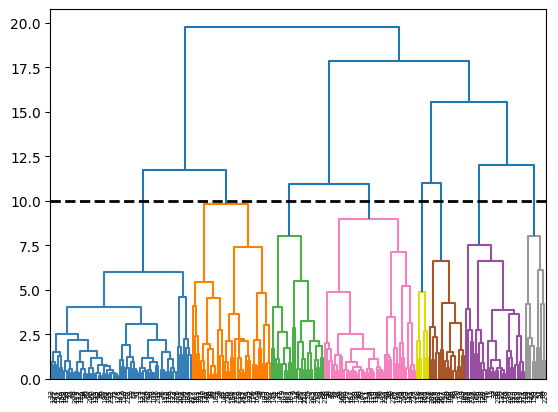

In [192]:
dist_thresh = 10

fig, ax = plt.subplots(1,1)
set_link_color_palette(cmap.colors)
dn = dendrogram(Z, color_threshold=dist_thresh, ax=ax, )
ax.axhline(y=dist_thresh, c="k", linewidth=2, linestyle="dashed")
#plt.savefig("figures/zonated_genes/dendrogram-pattern_clustering.pdf", bbox_inches="tight")
plt.show()

### Extract clusters

In [193]:
# get clusters
clusters = pd.Series(fcluster(Z, t=dist_thresh, criterion='distance'), index=dm.columns, name="cluster")

# map colors to clusters
lut = dict(zip(sorted(clusters.unique()), cmap.colors))
clustercolors = clusters.map(lut)

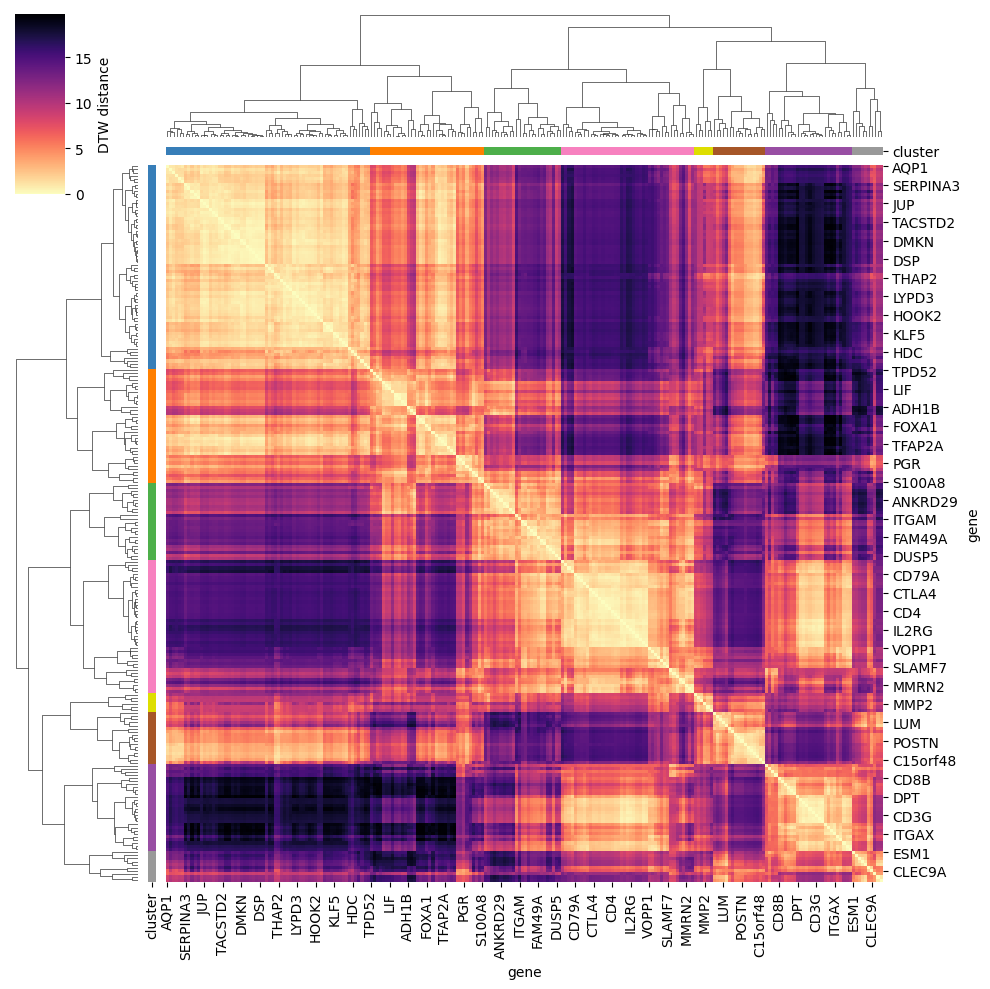

In [195]:
sns.clustermap(dm,
               cmap='magma_r',
               row_linkage=Z, col_linkage=Z,
               row_colors=clustercolors,
               col_colors=clustercolors,
               dendrogram_ratio=0.15, colors_ratio=0.01,
               cbar_kws={
                   'label': 'DTW distance',
               }
              )

#plt.savefig("figures/zonated_genes/heatmap_pattern-clustering.pdf", bbox_inches="tight")
plt.show()

In [196]:
clustercounts = pd.DataFrame(clusters.value_counts()).sort_index()
clustercounts.index.names = ["cluster"]
clustercounts.columns = ["counts"]

C:\Users\ge37voy\AppData\Local\Temp\ipykernel_9076\1440509162.py:2: UserWarning: The palette list has more values (9) than needed (8), which may not be intended.
  sns.barplot(data=clustercounts.reset_index(), x="cluster", y="counts", palette=cmap.colors, ax=ax)


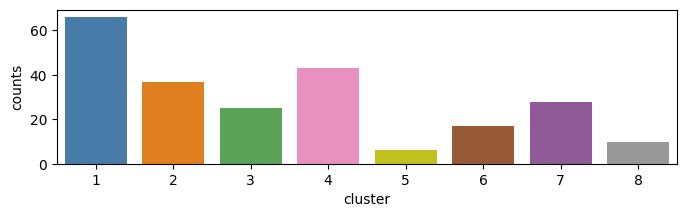

In [197]:
fig, ax = plt.subplots(1,1,figsize=(8,2))
sns.barplot(data=clustercounts.reset_index(), x="cluster", y="counts", palette=cmap.colors, ax=ax)
#plt.savefig("figures/zonated_genes/barplot_clusters.pdf", bbox_inches="tight")
plt.show()

## Plot genes per cluster

In [203]:
cc = clusters.unique()
for c in cc:
    genes = clusters.index[clusters == c]
    expr_along_obs_val(_adata, keys=genes, obs_val=("distance_from", "Tumor cells"),
                             max_cols=6, stderr=True, figsize=(8,4), title_fontsize=40,
                             save_only=True,
                             savepath="figures/zonated_genes/lineplot_cluster-patterning_cluster{}.pdf".format(c)
                            )

Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster6.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster1.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster7.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster2.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster3.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster4.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster8.pdf
Saved.
Retrieve `obs_val` from .obsm.
Saving figure to file figures/zonated_genes/lineplot_cluster-patterning_cluster5.pdf
Saved.


In [ ]:
expr_along_obs_val(adata=xd.cells.matrix,
                   keys=significant_genes[:8],
                   obs_val=("distance_from", "Tumor cells"),
                   stderr=True,
                   )

## Generate mean regression line per cluster

In [198]:
from sklearn.preprocessing import minmax_scale

In [199]:
# scale
norm_minmax = pd.DataFrame(minmax_scale(norm, axis=1), index=norm.index, columns=norm.columns) * 100

# add cluster information
df = pd.merge(left=norm_minmax, right=clusters, left_index=True, right_index=True)

# reshape to long format
df = df.reset_index().melt(id_vars=["gene", "cluster"], var_name="pos", value_name="expression [%]")

# scale position between 0 and 1
df["pos"] = df["pos"] / df["pos"].max()

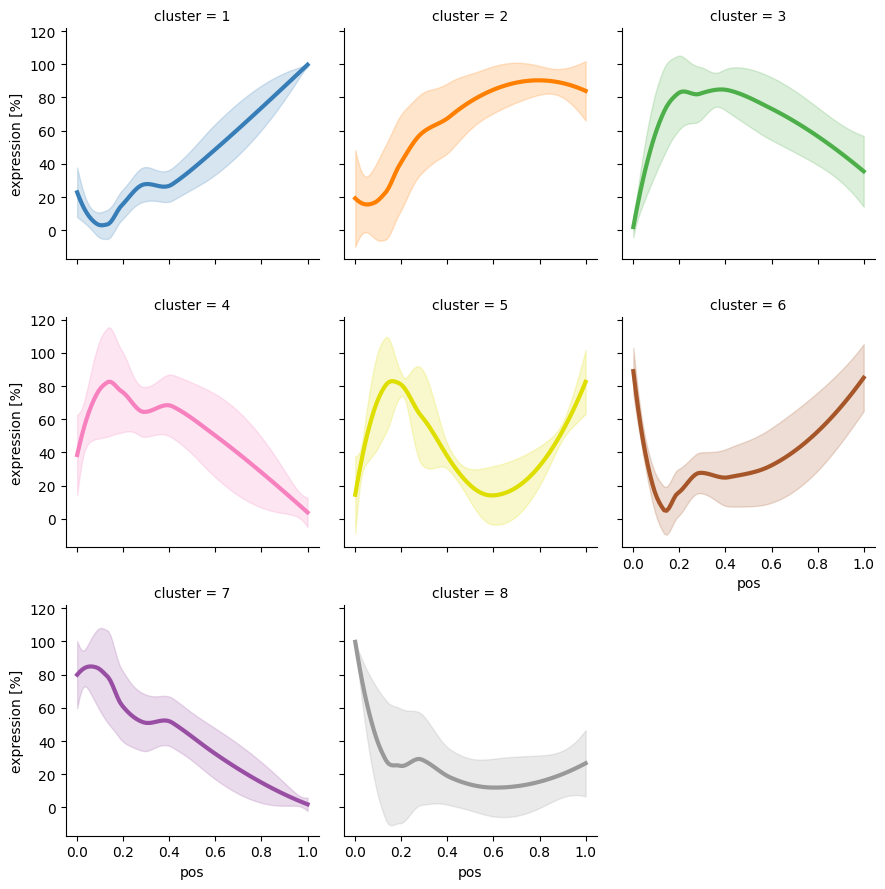

In [200]:
g = sns.FacetGrid(df, col="cluster", hue="cluster", palette=cmap.colors, col_wrap=3)
g.map(sns.lineplot, "pos", "expression [%]", ci="sd", linewidth=3)

#plt.savefig("figures/zonated_genes/lineplot_centerline-per-cluster.pdf", bbox_inches="tight")
plt.show()

## Autocorrelation function

In [ ]:
xd.show()

In [ ]:
#define data
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]

import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [ ]:
#define data
x = [22, 24, 25, 25, 28, 29, 34, 37, 40, 44, 51, 48, 47, 50, 51]

import statsmodels.api as sm

#calculate autocorrelations
sm.tsa.acf(x)

array([ 1.        ,  0.83174224,  0.65632458,  0.49105012,  0.27863962,
        0.03102625, -0.16527446, -0.30369928, -0.40095465, -0.45823389,
       -0.45047733, -0.36933174])

In [ ]:
sm.tsa.acf(x, nlags=5, fft=False)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962,
       0.03102625])

In [ ]:
sm.tsa.acf(x, nlags=5, fft=True)

array([1.        , 0.83174224, 0.65632458, 0.49105012, 0.27863962,
       0.03102625])

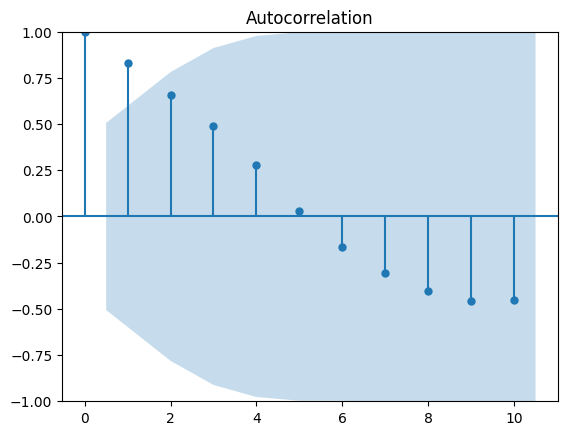

In [ ]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=10)
plt.show()

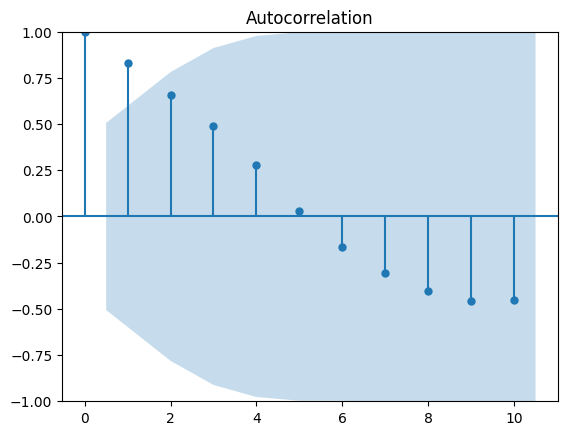

In [ ]:
from statsmodels.graphics import tsaplots
import matplotlib.pyplot as plt

#plot autocorrelation function
fig = tsaplots.plot_acf(x, lags=10, fft=True)
plt.show()

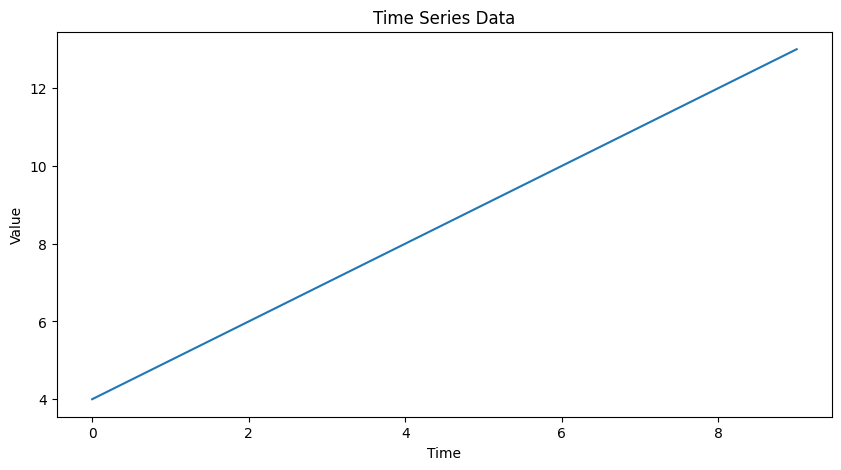

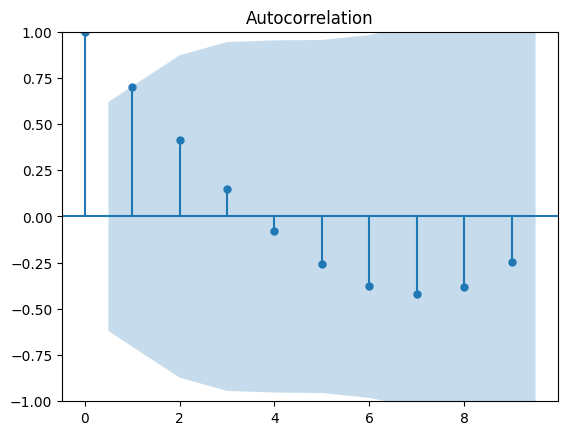

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 9 must be < 5.

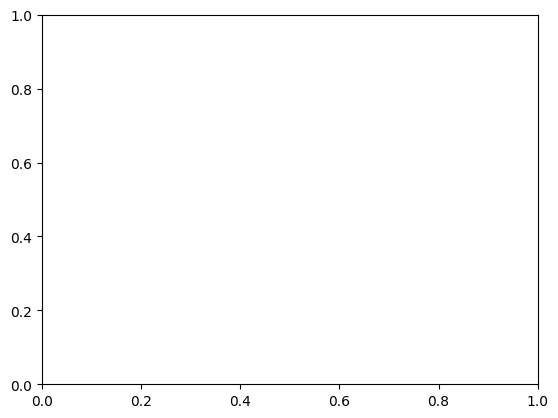

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf, adfuller, q_stat
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Example time series data
time_series_data = np.array([4, 5, 6, 7, 8, 9, 10, 11, 12, 13])

# Plot the time series
plt.figure(figsize=(10, 5))
plt.plot(time_series_data)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series Data')
plt.show()

# ACF and PACF plots
plot_acf(time_series_data, lags=9)
plt.show()

plot_pacf(time_series_data, lags=9)
plt.show()

# Augmented Dickey-Fuller test
adf_result = adfuller(time_series_data)
print('ADF Statistic:', adf_result)
print('p-value:', adf_result)

# Ljung-Box test
lb_test = q_stat(acf(time_series_data, nlags=9, fft=False)[1:], len(time_series_data))
print('Ljung-Box Q-statistic:', lb_test)
print('p-values:', lb_test)
